In [9]:
import keras
from __future__ import print_function
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Maximum, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, Reshape, GaussianNoise, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import random
import numpy as np
from sklearn.metrics import confusion_matrix
from random import randint
from scipy.ndimage import rotate
import math
from scipy import misc
import scipy.ndimage
from sklearn.metrics import confusion_matrix
from keras import regularizers
from numpy.random import permutation
from keras import metrics
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sys, glob, argparse
import numpy as np
import math, cv2
from scipy.stats import multivariate_normal
import time
from sklearn import svm
from numpy.testing import assert_allclose
from skimage.measure import shannon_entropy
import numpy as np
import matplotlib
import pylidc as pl
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from keras.layers.merge import concatenate
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.applications.mobilenet import MobileNet
from scipy.misc import imresize
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from sklearn.model_selection import StratifiedKFold
from scipy.misc import imread
from keras import backend as k
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from scipy import ndimage
from sklearn.feature_extraction import image as image_patch
from scipy.misc import imsave
from skimage.transform import rotate
import timeit

In [11]:
def get_mobilenet_model():
    #base_model  = MobileNet(input_shape=(128,128,3), include_top=False)
    base_model  = MobileNet(input_shape=(224,224,3), include_top=False)
    #base_model  = ResNet50(input_shape=(224,224,3), include_top=False)
    #base_model  = VGG16(input_shape=(224,224,3), include_top=False)
    #base_model  = InceptionV3(input_shape=(224,224,3), include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    sgd = optimizers.SGD(lr=0.0001)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    #print (model.summary())
    return model
#get_mobilenet_model()

In [12]:
#TRAINING FOR CLASSIFICATION
ensemble = 1
init_weights =  None

#filesc    = glob.glob('/media/pranjal/part2/FILTERDATANEW_h/*.npy')

all_accu  = []
all_accua = []


filepath_a = '/home/mallesh/Desktop/HPE/pranjal/2-3-div/'

def read_files(files, test_data, test_data_label):
    for f in files:
        t = imread(f)
        t = t/255.0
        test_data.append(t)
        fn = '_'.join(f.split('/')[-1].split('.')[0].split('_')[1:])
        test_data_label.append(fn)
    return [test_data, test_data_label]


def get_test_data(crsd):
    files1 = glob.glob(filepath_a+'Test/fold'+str(crsd)+'/1/*.jpg')
    files2 = glob.glob(filepath_a+'Test/fold'+str(crsd)+'/2/*.jpg')
    test_data = []
    test_data_label = []
    
    test_data, test_data_label = read_files(files1, test_data, test_data_label)
    test_data, test_data_label = read_files(files2, test_data, test_data_label)
    
    malignancy_label_test = []
    file_label    = []
    ml            = []
    orig_filename = []
    
    for idk, t in enumerate(test_data_label):
        label_data = t.split('_')
        pv = t.split('_')[-2]
        temp = [0, 0]
        temp[int(pv)-1] = 1
        malignancy_label_test.append(temp)
        file_label.append(t)
        ml.append(pv)
    
    malignancy_label_test = np.array(malignancy_label_test)
    test_data = np.array(test_data)
    
    return [test_data, malignancy_label_test, file_label, ml]


batch_size = 32


for crsd in range(1, 11):
    print('FOLD STARTED ', crsd)
    start_time = timeit.default_timer()

    model = get_mobilenet_model()
    
    train_datagen      = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        filepath_a+'Train/fold'+str(crsd)+'/',
        batch_size=32,
        target_size=(224, 224))

    validation_generator = validation_datagen.flow_from_directory(
        filepath_a+'Validation/fold'+str(crsd)+'/',
        batch_size=128,
        target_size=(224, 224))
    
    filepath   = filepath_a+'small_model/'+str(ensemble)+'_'+str(batch_size)+'_batch_'+str(crsd)+'_2_3_div_mobilenet_weights.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0000001)
    er         = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
    
    model.fit_generator(train_generator,
        steps_per_epoch=400,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=40,
        callbacks=[reduce_lr, er, checkpoint])
    
    model.load_weights(filepath) # restore the weight with best validation loss
    
    train_data      = []
    validation_data = []
    
    test_data, malignancy_label_test, file_label, ml = get_test_data(crsd)
    
    predictions           = model.predict(test_data, batch_size=100)
    all_predictions_value = predictions
    predictions_prob      = predictions
    
    ids        = {}
    true_value = {}
    value_hash = {'1':0, '2':1}
    for i, (ja, jb), k in zip(file_label, predictions, ml):
        nid = i
        true_value[nid] = value_hash[k] #same for each value therefore it overwrites the older value
        ids.setdefault(nid, [0, 0, 0, 0])
        ids[nid][0] = ids[nid][0]+ja
        ids[nid][1] = ids[nid][1]+jb

    for i, j, k in zip(file_label, predictions, ml):
        nid = i
        true_value[nid] = value_hash[k]
    final_pred      = []
    incorrect_files = []
    for nid in ids:
        if np.argmax(ids[nid]) != true_value[nid]:
            incorrect_files.append(nid)
        final_pred.append([nid, np.argmax(ids[nid]), true_value[nid]])
    final_pred = np.array(final_pred)
    
    #print(incorrect_files)
    cm    = confusion_matrix(final_pred[:, 2], final_pred[:, 1])
    print(cm)
    sums2 = np.sum(cm, axis=1) 
    sums1 = [] 
    sums1.append(cm[0][0]) 
    sums1.append(cm[1][1])
    ac   = 0 
    numc = 0
    denc = 0
    for i, j in zip(sums1, sums2): 
        ac   += i/(j*1.0)
        numc = numc+i
        denc = denc+j
    
    accu = ac/2.0
    print(accu)
    all_accu.append(accu)
    all_accua.append(numc/denc)
    stop_time = timeit.default_timer()

print(stop_time-start_time)

print('AVERAGE IS ', np.average(all_accu))
print('AVERAGE IS ', np.average(all_accua))

FOLD STARTED  1
Found 11970 images belonging to 2 classes.
Found 1329 images belonging to 2 classes.
Epoch 1/50
399/400 [============================>.] - ETA: 0s - loss: 0.7113
Epoch 00001: val_loss improved from inf to 0.68966, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_1_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 126s 316ms/step - loss: 0.7113 - val_loss: 0.6897
Epoch 2/50
399/400 [============================>.] - ETA: 0s - loss: 0.6775
Epoch 00002: val_loss improved from 0.68966 to 0.66498, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_1_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 296ms/step - loss: 0.6775 - val_loss: 0.6650
Epoch 3/50
399/400 [============================>.] - ETA: 0s - loss: 0.6561
Epoch 00003: val_loss improved from 0.66498 to 0.64733, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_1_2_3_div_mob

400/400 [==============================] - 117s 293ms/step - loss: 0.3717 - val_loss: 0.3942
Epoch 27/50
399/400 [============================>.] - ETA: 0s - loss: 0.3656
Epoch 00027: val_loss improved from 0.39425 to 0.38215, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_1_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 293ms/step - loss: 0.3654 - val_loss: 0.3821
Epoch 28/50
399/400 [============================>.] - ETA: 0s - loss: 0.3631
Epoch 00028: val_loss did not improve
400/400 [==============================] - 118s 295ms/step - loss: 0.3628 - val_loss: 0.3871
Epoch 29/50
399/400 [============================>.] - ETA: 0s - loss: 0.3561
Epoch 00029: val_loss did not improve
400/400 [==============================] - 118s 295ms/step - loss: 0.3561 - val_loss: 0.3844
Epoch 30/50
399/400 [============================>.] - ETA: 0s - loss: 0.3521
Epoch 00030: val_loss improved from 0.38215 to 0.37990, saving model to 

400/400 [==============================] - 119s 297ms/step - loss: 0.5096 - val_loss: 0.5120
Epoch 11/50
399/400 [============================>.] - ETA: 0s - loss: 0.4971
Epoch 00011: val_loss improved from 0.51202 to 0.49246, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_2_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 297ms/step - loss: 0.4971 - val_loss: 0.4925
Epoch 12/50
399/400 [============================>.] - ETA: 0s - loss: 0.4814
Epoch 00012: val_loss improved from 0.49246 to 0.48845, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_2_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 120s 299ms/step - loss: 0.4816 - val_loss: 0.4885
Epoch 13/50
399/400 [============================>.] - ETA: 0s - loss: 0.4747
Epoch 00013: val_loss improved from 0.48845 to 0.47965, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_2_2_3_div_mobi

399/400 [============================>.] - ETA: 0s - loss: 0.3411
Epoch 00037: val_loss improved from 0.37144 to 0.36171, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_2_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 298ms/step - loss: 0.3411 - val_loss: 0.3617
Epoch 38/50
399/400 [============================>.] - ETA: 0s - loss: 0.3321
Epoch 00038: val_loss did not improve
400/400 [==============================] - 119s 297ms/step - loss: 0.3320 - val_loss: 0.3735
Epoch 39/50
399/400 [============================>.] - ETA: 0s - loss: 0.3275
Epoch 00039: val_loss improved from 0.36171 to 0.35507, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_2_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 297ms/step - loss: 0.3274 - val_loss: 0.3551
Epoch 40/50
399/400 [============================>.] - ETA: 0s - loss: 0.3294
Epoch 00040: val_loss did not improve
400/400 [

400/400 [==============================] - 117s 292ms/step - loss: 0.4670 - val_loss: 0.4805
Epoch 13/50
399/400 [============================>.] - ETA: 0s - loss: 0.4499
Epoch 00013: val_loss improved from 0.48046 to 0.46935, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_3_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 291ms/step - loss: 0.4500 - val_loss: 0.4694
Epoch 14/50
399/400 [============================>.] - ETA: 0s - loss: 0.4469
Epoch 00014: val_loss improved from 0.46935 to 0.45879, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_3_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 294ms/step - loss: 0.4467 - val_loss: 0.4588
Epoch 15/50
399/400 [============================>.] - ETA: 0s - loss: 0.4322
Epoch 00015: val_loss improved from 0.45879 to 0.45117, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_3_2_3_div_mobi

400/400 [==============================] - 116s 290ms/step - loss: 0.3281 - val_loss: 0.3571
Epoch 38/50
399/400 [============================>.] - ETA: 0s - loss: 0.3236
Epoch 00038: val_loss did not improve
400/400 [==============================] - 116s 290ms/step - loss: 0.3233 - val_loss: 0.3572
Epoch 39/50
399/400 [============================>.] - ETA: 0s - loss: 0.3175
Epoch 00039: val_loss did not improve
400/400 [==============================] - 117s 291ms/step - loss: 0.3171 - val_loss: 0.3576
Epoch 40/50
399/400 [============================>.] - ETA: 0s - loss: 0.3133
Epoch 00040: val_loss improved from 0.35706 to 0.35116, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_3_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 116s 291ms/step - loss: 0.3136 - val_loss: 0.3512
Epoch 41/50
399/400 [============================>.] - ETA: 0s - loss: 0.3094
Epoch 00041: val_loss improved from 0.35116 to 0.34714, saving model to 

Epoch 15/50
399/400 [============================>.] - ETA: 0s - loss: 0.4215
Epoch 00015: val_loss improved from 0.45974 to 0.45220, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_4_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 294ms/step - loss: 0.4215 - val_loss: 0.4522
Epoch 16/50
399/400 [============================>.] - ETA: 0s - loss: 0.4188
Epoch 00016: val_loss did not improve
400/400 [==============================] - 118s 296ms/step - loss: 0.4187 - val_loss: 0.4748
Epoch 17/50
399/400 [============================>.] - ETA: 0s - loss: 0.4115
Epoch 00017: val_loss did not improve
400/400 [==============================] - 117s 293ms/step - loss: 0.4115 - val_loss: 0.4554
Epoch 18/50
399/400 [============================>.] - ETA: 0s - loss: 0.4088
Epoch 00018: val_loss did not improve
400/400 [==============================] - 116s 291ms/step - loss: 0.4090 - val_loss: 0.4652
Epoch 19/50
399/400 [=============

Epoch 46/50
399/400 [============================>.] - ETA: 0s - loss: 0.2933
Epoch 00046: val_loss did not improve
400/400 [==============================] - 117s 293ms/step - loss: 0.2930 - val_loss: 0.3704
Epoch 47/50
399/400 [============================>.] - ETA: 0s - loss: 0.2928
Epoch 00047: val_loss improved from 0.36581 to 0.35584, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_4_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 292ms/step - loss: 0.2926 - val_loss: 0.3558
Epoch 48/50
399/400 [============================>.] - ETA: 0s - loss: 0.2898
Epoch 00048: val_loss did not improve
400/400 [==============================] - 117s 292ms/step - loss: 0.2894 - val_loss: 0.3599
Epoch 49/50
399/400 [============================>.] - ETA: 0s - loss: 0.2839
Epoch 00049: val_loss did not improve
400/400 [==============================] - 117s 293ms/step - loss: 0.2840 - val_loss: 0.3605
Epoch 50/50
399/400 [=============

400/400 [==============================] - 119s 298ms/step - loss: 0.3806 - val_loss: 0.3871
Epoch 23/50
399/400 [============================>.] - ETA: 0s - loss: 0.3748
Epoch 00023: val_loss improved from 0.38711 to 0.38277, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_5_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 121s 301ms/step - loss: 0.3750 - val_loss: 0.3828
Epoch 24/50
399/400 [============================>.] - ETA: 0s - loss: 0.3760
Epoch 00024: val_loss improved from 0.38277 to 0.37980, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_5_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 120s 301ms/step - loss: 0.3760 - val_loss: 0.3798
Epoch 25/50
399/400 [============================>.] - ETA: 0s - loss: 0.3615
Epoch 00025: val_loss improved from 0.37980 to 0.37725, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_5_2_3_div_mobi

[[78  9]
 [10 34]]
0.8346394984326019
FOLD STARTED  6
Found 11969 images belonging to 2 classes.
Found 1329 images belonging to 2 classes.
Epoch 1/50
399/400 [============================>.] - ETA: 0s - loss: 0.6998
Epoch 00001: val_loss improved from inf to 0.67116, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_6_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 153s 383ms/step - loss: 0.6996 - val_loss: 0.6712
Epoch 2/50
399/400 [============================>.] - ETA: 0s - loss: 0.6465
Epoch 00002: val_loss improved from 0.67116 to 0.63923, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_6_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 295ms/step - loss: 0.6464 - val_loss: 0.6392
Epoch 3/50
399/400 [============================>.] - ETA: 0s - loss: 0.6116
Epoch 00003: val_loss improved from 0.63923 to 0.61092, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-di

399/400 [============================>.] - ETA: 0s - loss: 0.3788
Epoch 00025: val_loss did not improve
400/400 [==============================] - 118s 296ms/step - loss: 0.3788 - val_loss: 0.4196
Epoch 26/50
399/400 [============================>.] - ETA: 0s - loss: 0.3706
Epoch 00026: val_loss improved from 0.41922 to 0.40932, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_6_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 293ms/step - loss: 0.3705 - val_loss: 0.4093
Epoch 27/50
399/400 [============================>.] - ETA: 0s - loss: 0.3645
Epoch 00027: val_loss did not improve
400/400 [==============================] - 118s 294ms/step - loss: 0.3644 - val_loss: 0.4145
Epoch 28/50
399/400 [============================>.] - ETA: 0s - loss: 0.3634
Epoch 00028: val_loss did not improve
400/400 [==============================] - 118s 295ms/step - loss: 0.3634 - val_loss: 0.4105
Epoch 29/50
399/400 [=========================

Epoch 5/50
399/400 [============================>.] - ETA: 0s - loss: 0.5644
Epoch 00005: val_loss improved from 0.56484 to 0.54412, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_7_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 122s 305ms/step - loss: 0.5644 - val_loss: 0.5441
Epoch 6/50
399/400 [============================>.] - ETA: 0s - loss: 0.5440
Epoch 00006: val_loss improved from 0.54412 to 0.52125, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_7_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 123s 307ms/step - loss: 0.5439 - val_loss: 0.5213
Epoch 7/50
399/400 [============================>.] - ETA: 0s - loss: 0.5278
Epoch 00007: val_loss improved from 0.52125 to 0.50608, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_7_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 121s 304ms/step - loss: 0.5274 - val

400/400 [==============================] - 122s 304ms/step - loss: 0.3581 - val_loss: 0.3638
Epoch 31/50
399/400 [============================>.] - ETA: 0s - loss: 0.3527
Epoch 00031: val_loss did not improve
400/400 [==============================] - 122s 304ms/step - loss: 0.3526 - val_loss: 0.3651
Epoch 32/50
399/400 [============================>.] - ETA: 0s - loss: 0.3452
Epoch 00032: val_loss improved from 0.36383 to 0.35955, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_7_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 123s 307ms/step - loss: 0.3452 - val_loss: 0.3596
Epoch 33/50
399/400 [============================>.] - ETA: 0s - loss: 0.3431
Epoch 00033: val_loss did not improve
400/400 [==============================] - 122s 306ms/step - loss: 0.3429 - val_loss: 0.3612
Epoch 34/50
399/400 [============================>.] - ETA: 0s - loss: 0.3402
Epoch 00034: val_loss improved from 0.35955 to 0.35616, saving model to 

Epoch 8/50
399/400 [============================>.] - ETA: 0s - loss: 0.5072
Epoch 00008: val_loss improved from 0.51871 to 0.51022, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_8_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 297ms/step - loss: 0.5068 - val_loss: 0.5102
Epoch 9/50
399/400 [============================>.] - ETA: 0s - loss: 0.4944
Epoch 00009: val_loss improved from 0.51022 to 0.49453, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_8_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 296ms/step - loss: 0.4940 - val_loss: 0.4945
Epoch 10/50
399/400 [============================>.] - ETA: 0s - loss: 0.4719
Epoch 00010: val_loss improved from 0.49453 to 0.49198, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_8_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 296ms/step - loss: 0.4719 - va

400/400 [==============================] - 119s 297ms/step - loss: 0.3330 - val_loss: 0.3776
Epoch 36/50
399/400 [============================>.] - ETA: 0s - loss: 0.3258
Epoch 00036: val_loss improved from 0.37758 to 0.37748, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_8_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 296ms/step - loss: 0.3255 - val_loss: 0.3775
Epoch 37/50
399/400 [============================>.] - ETA: 0s - loss: 0.3225
Epoch 00037: val_loss improved from 0.37748 to 0.36961, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_8_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 298ms/step - loss: 0.3223 - val_loss: 0.3696
Epoch 38/50
399/400 [============================>.] - ETA: 0s - loss: 0.3255
Epoch 00038: val_loss did not improve
400/400 [==============================] - 119s 296ms/step - loss: 0.3258 - val_loss: 0.3766
Epoch 39/50
399/400 

Epoch 13/50
399/400 [============================>.] - ETA: 0s - loss: 0.4460
Epoch 00013: val_loss improved from 0.46782 to 0.45159, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_9_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 296ms/step - loss: 0.4459 - val_loss: 0.4516
Epoch 14/50
399/400 [============================>.] - ETA: 0s - loss: 0.4388
Epoch 00014: val_loss did not improve
400/400 [==============================] - 119s 297ms/step - loss: 0.4391 - val_loss: 0.4882
Epoch 15/50
399/400 [============================>.] - ETA: 0s - loss: 0.4324
Epoch 00015: val_loss improved from 0.45159 to 0.44073, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_9_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 118s 296ms/step - loss: 0.4324 - val_loss: 0.4407
Epoch 16/50
399/400 [============================>.] - ETA: 0s - loss: 0.4222
Epoch 00016: val_loss improved from

400/400 [==============================] - 120s 300ms/step - loss: 0.3040 - val_loss: 0.3354
Epoch 42/50
399/400 [============================>.] - ETA: 0s - loss: 0.3087
Epoch 00042: val_loss improved from 0.33540 to 0.33253, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_9_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 120s 300ms/step - loss: 0.3086 - val_loss: 0.3325
Epoch 43/50
399/400 [============================>.] - ETA: 0s - loss: 0.3068
Epoch 00043: val_loss improved from 0.33253 to 0.33049, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_9_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 119s 298ms/step - loss: 0.3070 - val_loss: 0.3305
Epoch 44/50
399/400 [============================>.] - ETA: 0s - loss: 0.2982
Epoch 00044: val_loss improved from 0.33049 to 0.32798, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_9_2_3_div_mobi

400/400 [==============================] - 117s 292ms/step - loss: 0.4241 - val_loss: 0.4232
Epoch 17/50
399/400 [============================>.] - ETA: 0s - loss: 0.4164
Epoch 00017: val_loss did not improve
400/400 [==============================] - 117s 292ms/step - loss: 0.4161 - val_loss: 0.4238
Epoch 18/50
399/400 [============================>.] - ETA: 0s - loss: 0.4043
Epoch 00018: val_loss improved from 0.42317 to 0.41757, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_10_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 293ms/step - loss: 0.4039 - val_loss: 0.4176
Epoch 19/50
399/400 [============================>.] - ETA: 0s - loss: 0.4011
Epoch 00019: val_loss improved from 0.41757 to 0.41060, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_10_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 292ms/step - loss: 0.4014 - val_loss: 0.4106
Epoch 20/50
399/40

Epoch 46/50
399/400 [============================>.] - ETA: 0s - loss: 0.2861
Epoch 00046: val_loss did not improve
400/400 [==============================] - 116s 289ms/step - loss: 0.2858 - val_loss: 0.3323
Epoch 47/50
399/400 [============================>.] - ETA: 0s - loss: 0.2869
Epoch 00047: val_loss improved from 0.33148 to 0.33042, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_10_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 292ms/step - loss: 0.2867 - val_loss: 0.3304
Epoch 48/50
399/400 [============================>.] - ETA: 0s - loss: 0.2860
Epoch 00048: val_loss improved from 0.33042 to 0.32927, saving model to /home/mallesh/Desktop/HPE/pranjal/2-3-div/small_model/1_32_batch_10_2_3_div_mobilenet_weights.h5
400/400 [==============================] - 117s 292ms/step - loss: 0.2859 - val_loss: 0.3293
Epoch 49/50
399/400 [============================>.] - ETA: 0s - loss: 0.2777
Epoch 00049: val_loss did not imp

In [ ]:
#Get AUCs
from sklearn.metrics import roc_auc_score, roc_curve, auc

def get_roc(xtest, ytest, clf):
    ypred = clf.predict(xtest) # if you already have ypred, pass it as parameter instead of ytest.
    fpr, tpr, thresholds = roc_curve(ytest, ypred)
    auc_score = auc(fpr, tpr)
    ruc_score = roc_auc_score(ytest, ypred)
    return auc_score, ruc_score
    

In [14]:
p = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)


574046208/574710816 [============================>.] - ETA: 0s

In [ ]:
#For saving the single images
from scipy.misc import imsave
import os

for crsd in range(1, 4):
    counter = 0
    print(crsd)
    #try:
    filepath_a = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/cross-data-10-14-div-'
    filepath_b = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/10-14-div/Train/'

    for index in range(0, 50):
        try:
            train_data       = np.load(filepath_a+str(crsd)+'-index'+str(index)+'-Train-c-color.npy')
            train_data_label = np.load(filepath_a+str(crsd)+'-index'+str(index)+'-Train-c-name.npy')
            for i, d in enumerate(train_data):
                t = train_data_label[i]
                l = t.split('_')[-2]
                imsave(filepath_b+'fold'+str(crsd)+'/'+l+'/'+str(counter)+'_'+train_data_label[i]+'.jpg', train_data[i])
                counter = counter+1
            os.remove(filepath_a+str(crsd)+'-index'+str(index)+'-Train-c-color.npy')
            os.remove(filepath_a+str(crsd)+'-index'+str(index)+'-Train-c-name.npy')
        except Exception as err:
            print(err, 'file not found')
    #except:
    #    print('file note found')

1


/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


2
3


In [33]:
#For creating the validation set
for crsd in range(1, 11):
    print(crsd)
    files1  = glob.glob('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/2-3-div/Train/fold'+str(crsd)+'/1/*')
    files2  = glob.glob('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/2-3-div/Train/fold'+str(crsd)+'/2/*')
    random.shuffle(files1)
    random.shuffle(files2)
    f1 = int(len(files1)/10)
    f2 = int(len(files2)/10)
    for f in files1[:f1]:
        newpath = f.replace('Train', 'Validation')
        os.rename(f, newpath)
    for f in files2[:f2]:
        newpath = f.replace('Train', 'Validation')
        os.rename(f, newpath)

1
2
3
4
5
6
7
8
9
10


In [10]:
def get_file_name(name):
    fn = '_'.join(name.split('/')[-1].split('.')[0].split('_')[1:])
    return fn
#print(get_file_name(files[0]))

In [22]:
# FOR TAKING MAX POOLING OF FEATURES

crsd  = 1
#model = get_mobilenet_model()
model = get_mobilenet_model()
split = 'Test'
b     = 32
ensemble = 1

def get_data_from_folder(files, label, start, batch):
    test_data = []
    test_data_label = []
    for j in range(start, start+batch):
        test_data.append(imread(files[j])/255.0)
        #fn = files[j]
        fn = get_file_name(files[j])
        test_data_label.append(fn)
    test_data = np.array(test_data)
    test_data_label = np.array(test_data_label)
    return test_data, test_data_label

def get_features(files1, files2):
    test_data_label = []
    features = []
    
    for i in range(int(len(files1)/128)):
        start = i*128
        test_data_temp, test_data_label_temp = get_data_from_folder(files1, [1, 0], start, 128)
        features_temp = intermediate_layer_model.predict(test_data_temp)
        for t in features_temp:
            features.append(t)
        for t in test_data_label_temp:
            test_data_label.append(t)
    
    for i in range(int(len(files2)/128)):
        start = i*128
        test_data_temp, test_data_label_temp = get_data_from_folder(files2, [0, 1], start, 128)
        features_temp = intermediate_layer_model.predict(test_data_temp)
        for t in features_temp:
            features.append(t)
        for t in test_data_label_temp:
            test_data_label.append(t)
    
    test_data_label = np.array(test_data_label)
    features = np.array(features)
    
    return features, test_data_label

for crsd in range(1,11):
    #'/mnt/small_model/'+str(ensemble)+'_'+str(b)+'_batch_'+str(crsd)+'_weights.h5'
    model.load_weights('/mnt/small_model/'+str(ensemble)+'_'+str(b)+'_batch_'+str(crsd)+'_mobilenet_weights.h5')
        
    files1 = glob.glob('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/'+split+'/fold'+str(crsd)+'/1/*.jpg')
    files2 = glob.glob('/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/'+split+'/fold'+str(crsd)+'/2/*.jpg')
    
    layer_name = model.layers[-2].name
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    features, test_data_label = get_features(files1, files2)
        
    h = {}
    for i, t in enumerate(test_data_label):
        h.setdefault(t, [])
        h[t].append(features[i])
    for k in h:
        h[k] = np.max(h[k], axis=0)
    features_name = []
    features = []
    for k in h:
        features_name.append(k)
        features.append(h[k])
    features = np.array(features)
    features_name = np.array(features_name)
    print('SAVING FILE ', crsd)
    print(features_name.shape)
    print(features.shape)
    #np.save('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_features.h5', features)
    #np.save('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_features_names.h5', features_name)
    np.save('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features.h5', features)
    np.save('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features_names.h5', features_name)
    


/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


SAVING FILE  1
(131,)
(131, 1024)
SAVING FILE  2
(131,)
(131, 1024)
SAVING FILE  3
(131,)
(131, 1024)
SAVING FILE  4
(131,)
(131, 1024)
SAVING FILE  5
(131,)
(131, 1024)
SAVING FILE  6
(131,)
(131, 1024)
SAVING FILE  7
(130,)
(130, 1024)
SAVING FILE  8
(130,)
(130, 1024)
SAVING FILE  9
(130,)
(130, 1024)
SAVING FILE  10
(129,)
(129, 1024)


In [38]:
# TAKES THE ORIGINAL MODEL AS INPUT AND OUTPUTS THE LATER HALF OF THE MODEL
def get_model_pool(model):
    main_input = Input(shape=(1024, ))
    malignancy        = Dense(2, activation='softmax')(main_input)
    pool_model = Model(inputs=[main_input], outputs=[malignancy])
    # SETTING WEIGHTS FOR LATER HALF
    layer_name = model.layers[-1].name
    layer      = model.get_layer(layer_name)
    weights    = layer.get_weights()
    #sgd = optimizers.SGD(lr=0.0001)
    pool_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',
                      metrics=[metrics.categorical_accuracy])
    new_layer_name = pool_model.layers[-1].name
    newlayer       = pool_model.get_layer(new_layer_name)
    newlayer.set_weights(weights)
    return pool_model

In [43]:
model = get_mobilenet_model()
m = get_model_pool(model)
print(m.summary())

m.layers.pop()
m.outputs = [m.layers[-1].output]
m.layers[-1].outbound_nodes = []
print(m.summary())

model.layers.pop()
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 2050      
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 1024)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 224, 224, 3)       0         
____

In [ ]:
# CODE FOR MAXPOOL

# CODE FOR TESTING IT
# DONT DELETE THIS COMMENT BLOCK


# def get_new_model_89_81_classify_pool():
#     main_input = Input(shape=(256, ))
#     malignancy        = Dense(2, activation='softmax')(main_input)
#     model = Model(inputs=[main_input], outputs=[malignancy])
#     return model

# crsd = 1
# filename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(crsd)+'-Test-c.npy'
# ar = np.load(filename)
# ar = np.expand_dims(ar, axis=3)

# pool_model  = get_new_model_89_81_classify_pool()
# model       = get_new_model_89_81_classify()

# layer_name = model.layers[-1].name
# layer      = model.get_layer(layer_name)
# weights    = layer.get_weights()

# new_layer_name = pool_model.layers[-1].name
# newlayer       = pool_model.get_layer(new_layer_name) 

# newlayer.set_weights(weights)

# layer_name = model.layers[-2].name
# intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# print(model.predict(ar)[0])

# feature = intermediate_layer_model.predict(ar)
# print(feature.shape)
# print(pool_model.predict(feature)[0])

# FOR PREDCITION USING MAX POOLING OF FEATURES

In [39]:
crsd  = 1
#model = get_new_model_89_81_classify()
model = get_mobilenet_model()

from sklearn.metrics import roc_auc_score

split = 'Test'
b = 32
ensemble = 1
all_accu = []
all_accua = []
sensi = []
speci = []
area = []

for crsd in range(1,11):
    print('starting batch ', crsd)
    traindata  = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_Train_mobilenet_features.h5.npy') 
    nodulenametrain = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_Train_mobilenet_features_names.h5.npy')
    
    maxpool    = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features.h5.npy')
    nodulename = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features_names.h5.npy')
    model.load_weights('/mnt/small_model/'+str(ensemble)+'_'+str(b)+'_batch_'+str(crsd)+'_mobilenet_weights.h5')
    
    #print('weights loaded')
    
    pool_model = get_model_pool(model)
    #pool_model   = get_new_model_89_81_classify_pool(model)
    
    h           = {}
    final_label = []
    train_label = []
    
    for t in nodulename:
        tp = int(t.split('_')[-2])-1
        final_label.append(tp)
    
    for t in nodulenametrain:
        tp = int(t.split('_')[-2])-1
        temp = [0, 0]
        temp[tp] = 1
        train_label.append(temp)
    
    train_label = np.array(train_label)
    final_label = np.array(final_label)
    
    #print(train_label.shape)
    #print(final_label.shape)
    
    #pool_model.fit([traindata], [train_label], epochs=40, batch_size=32, shuffle=True, verbose=False)
    
    final_output = pool_model.predict(maxpool)
    
    cm    = confusion_matrix(np.argmax(final_output, axis=1), final_label)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    ruc_score = roc_auc_score(final_label, final_output[:, 1])
    
    print('Sensitivity', sensitivity)
    print('Specifity', specificity)
    print('RUC score ', ruc_score)
    
    sensi.append(sensitivity)
    speci.append(specificity)
    area.append(ruc_score)
    
    sums2 = np.sum(cm, axis=1) 
    sums1 = [] 
    sums1.append(cm[0][0]) 
    sums1.append(cm[1][1])
    
    ac   = 0 
    numc = 0
    denc = 0
    for i, j in zip(sums1, sums2): 
        ac   += i/(j*1.0)
        numc = numc+i
        denc = denc+j
    accu = ac/2.0
    print(accu, numc/denc)
    
    all_accu.append(accu)
    all_accua.append(numc/denc)

print(np.average(all_accua))
print(np.average(sensi))
print(np.average(speci))
print(np.average(area))

starting batch  1
[[85 18]
 [ 2 26]]
Sensitivity 0.9285714285714286
Specifity 0.8252427184466019
RUC score  0.9294670846394985
0.8769070735090152 0.8473282442748091
starting batch  2
[[75  4]
 [12 40]]
Sensitivity 0.7692307692307693
Specifity 0.9493670886075949
RUC score  0.9521943573667713
0.8592989289191821 0.8778625954198473
starting batch  3
[[77  9]
 [10 35]]
Sensitivity 0.7777777777777778
Specifity 0.8953488372093024
RUC score  0.9234587251828632
0.8365633074935401 0.8549618320610687
starting batch  4
[[67  2]
 [20 42]]
Sensitivity 0.6774193548387096
Specifity 0.9710144927536232
RUC score  0.9647335423197492
0.8242169237961664 0.8320610687022901
starting batch  5
[[82 15]
 [ 5 29]]
Sensitivity 0.8529411764705882
Specifity 0.845360824742268
RUC score  0.9124869383490073
0.8491510006064281 0.8473282442748091
starting batch  6
[[78  8]
 [ 9 36]]
Sensitivity 0.8
Specifity 0.9069767441860465
RUC score  0.9268547544409613
0.8534883720930233 0.8702290076335878
starting batch  7
[[75  3]

In [29]:
print(np.std(all_accua))
print(np.std(speci))
print(np.std(sensi))
print(np.std(area))

0.031589136817382645
0.024017194952376662
0.07357675476292584
0.014094029345471498


In [54]:
crsd = 1
split =  'Train'
ensemble = 1
b = 32

model = get_mobilenet_model()
model.load_weights('/mnt/small_model/'+str(ensemble)+'_'+str(b)+'_batch_'+str(crsd)+'_mobilenet_weights.h5')
model = get_model_pool(model)

maxpool    = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features.h5.npy')
nodulename = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features_names.h5.npy')

train_label = []
for k in nodulename:
    if 'Susp' in k:
        train_label.append([0, 1])
    else:
        train_label.append([1, 0])

train_label = np.array(train_label)
model.fit(maxpool, train_label, epochs=40, batch_size=32, shuffle=True, verbose=False)


model.layers.pop()
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []
#print(model.summary())

X = model.predict(maxpool)
print(X.shape)

(1174, 1024)


In [55]:
y = []
for k in nodulename:
    if 'Susp' in k:
        y.append(1)
    else:
        y.append(0)

y = np.array(y)
print(y.shape)

(1174,)


In [60]:
filepath = '/home/pranjal/Desktop/mallesh/mobilenet-image-features/'
files = glob.glob(filepath+'*.npy')
axial_views = []
print(len(files))
maxp = {}
h  = {} #features
hf = {} #names
def get_file_name(name):
    fn = '_'.join(name.split('/')[-1].split('.')[0].split('_')[1:])
    return fn
for f in files:
    t = get_file_name(f)
    h[t] = np.load(f)
X = []
y = []
for k in h:
    X.append(h[k])
    if 'Susp' in k:
        y.append(1)
    else:
        y.append(0)

y = np.array(y)
X = np.array(X)
print(X.shape)

48224
(1174, 1024)


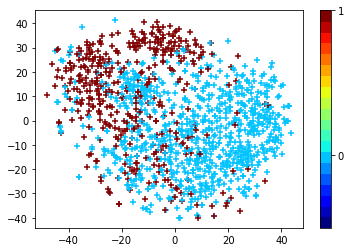

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

perplexity   = 30
n_components = 2

tsne = TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity)

red = y == 0
green = y == 1

vis_data = tsne.fit_transform(X)
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=y, cmap=plt.cm.get_cmap("jet", 20), marker='+')
plt.colorbar(ticks=range(50))
plt.clim(-0.5, 1)
plt.show()

In [175]:
# FOR PREDCITION USING MAX POOLING OF FEATURES FOR REGRESSION
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

crsd  = 1
model = get_mobilenet_model()

split = 'Test'
b     = 32
ensemble  = 1
all_accu  = []
all_accua = []

values = {}
files  = glob.glob('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/FILTERDATANEW_h/*')
for f in files:
    tp = f.split('/')[-1]
    a  = tp.split('.')[0]
    b  = float(tp.split('_')[-1][0:3])
    values[a] = b

for crsd in range(1,11):
    traindata       = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_Train_mobilenet_features.h5.npy') 
    nodulenametrain = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_Train_mobilenet_features_names.h5.npy')
    
    maxpool    = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features.h5.npy')
    nodulename = np.load('/mnt/small_model/1_128_batch_'+str(crsd)+'_'+split+'_mobilenet_features_names.h5.npy')
    
    h           = {}
    final_label = []
    train_label = []
    
    for t in nodulename:
        final_label.append(values[t])
    for t in nodulenametrain:
        train_label.append(values[t])
    
    train_label = np.array(train_label)
    final_label = np.array(final_label)
    
    p = np.random.permutation(len(traindata))
    traindata   = traindata[p]
    train_label = train_label[p]
 
    clf = LogisticRegression(solver='liblinear',n_jobs=-1, random_state=0, 
                        max_iter=400,  class_weight='balanced', intercept_scaling=0.001, C=0.01, tol=0.00001)
    #clf = SVR(C=1.0, epsilon=0.2, tol=0.0001, gamma=0.0001)
    #clf = RandomForestRegressor(max_depth=15, random_state=0)
    #clf = SGDRegressor(tol=0.001)
    
    #clf.fit(traindata, train_label)
    clf.fit(traindata, train_label.astype(int))
    
    #model.fit([traindata], [train_label], epochs=1000, batch_size=128, 
    #          shuffle=True, verbose=True, validation_split=0.1, callbacks=[reduce_lr, er, checkpoint])
    #model.load_weights(filepath)
    predictions = clf.predict(maxpool)
    predictions = predictions
    #print(predictions)
    count     = 0
    total     = len(predictions)
    incorrect = 0
    y_test    = final_label.astype(int)
    #y_test    = final_label
    
    for i, value in enumerate(predictions):
        if abs(value-y_test[i]) > 1:
            incorrect = incorrect+1
    s = 1-incorrect/total
    print(s)
    
#     count = 0
#     total = {}
#     incorrect = {}
#     y_test = final_label
#     for i, value in enumerate(predictions):
#         if str(y_test[i]) not in total:
#             total[str(y_test[i])] = 1 
#         else:
#             total[str(y_test[i])] = total[str(y_test[i])]+1
#         if abs(value-y_test[i]) > 1:
#             if str(y_test[i]) not in incorrect:
#                 incorrect[str(y_test[i])] = 1
#             else:
#                 incorrect[str(y_test[i])] = incorrect[str(y_test[i])] +1
#     s = 0
#     for k in total:
#         if k in incorrect:
#             ts = 1-incorrect[k]/total[k]   
#         else:
#             ts = 1
#         #print(k, ts)
#         s = s+ts
#     print(s/4.0)
    all_accu.append(s)
print(np.average(all_accu))

/home/pranjal/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.9618320610687023
0.9770992366412213
0.916030534351145
0.9312977099236641
0.9083969465648855
0.9312977099236641
0.9692307692307692
0.9307692307692308
0.9461538461538461
0.9069767441860466
0.9379084788813176


In [179]:
ans = predictions-value
print(np.mean(ans))

0.2713178294573643


In [ ]:
import pickle
pickle_out = pickle.load(open("alldata_70_classification_volume_plus_data.pickle","rb"))

In [ ]:
itr = 0
# dont use stratifidd kfodl
# use normal one#
#okay, I was unable to iterate  over
kf  = StratifiedKFold(n_splits=5, random_state=380, shuffle=False)
#kf  = KFold(n_splits=5, random_state=30, shuffle=False)
labels = []
for k in keys:
    tp = int(k.split('_')[-2])-1
    labels.append(tp)
split_data = kf.split(keys, labels)
#split_data = kf.split(keys)
ensemble   = 1
for train_keys, test_keys in split_data:
    itr += 1
    train_data = []
    test_data  = []
    classes    = get_empty_classes()
    for i in train_keys:
        train_data.append(alldata[keys[i]])
    for i in test_keys:
        test_data.append(alldata[keys[i]])
    for i in train_data:
        for j in i:
            classname = j[0].split('_')[-2]
            classes[classname].append(j)
    numpy_data = []
    name_data  = []
    for cls in classes:
        c = classes[cls]
        random.shuffle(c)
        for t in c:
            numpy_data.append(t[1])
            name_data.append(t[0])
    numpy_data   = np.array(numpy_data)
    tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Train-c.npy'
    np.save(tempfilename, numpy_data)
    name_data = np.array(name_data)
    tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Train-c-name.npy'
    np.save(tempfilename, name_data)
    classes    = get_empty_classes()
    for i in test_data:
        for j in i:
            classname = j[0].split('_')[-2]
            classes[classname].append(j)
    numpy_data = []
    name_data  = []
    for cls in classes:
        c = classes[cls]
        random.shuffle(c)
        for t in c:
            numpy_data.append(t[1])
            name_data.append(t[0])
    tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Test-c.npy'
    np.save(tempfilename, numpy_data)
    name_data = np.array(name_data)
    tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Test-c-name.npy'
    np.save(tempfilename, name_data)

In [34]:
# CODE WITH SPLIT
# CODE TO GENERATE TRAINING DATA
# WITH ALL THE SAMPLES 
# FOR CLASSIFICATION GOOD ONE

import os
import random
import numpy as np
from   sklearn.model_selection import KFold

import scipy.ndimage
import numpy as np
import math
from scipy import misc
import glob
from sklearn.model_selection import StratifiedKFold


count      = 0
checkcount = 0
checked = {}
checked_a = {}
checked_b = {}

files   = glob.glob('/media/pranjal/part2/FILTERDATANEW_h/volume*.npy') 
filessc = []
for f in files:
    at = f.replace('volume-', '')
    filessc.append(at)
files = filessc

alldata = {}

for name in files:
	nodule_id = name.split('.')[0]
	checked[nodule_id]   = name
	checked_a[nodule_id] = name.split('.')[0].split('/')[-1]
	checked_b[nodule_id] = name.split('_')[3]
	alldata[nodule_id]   = []

def rotation_matrix(axis, theta):
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])
from skimage import filters

def get_empty_classes():
    classes = {}
    classes['1']   = []
    classes['2']   = []
    return classes


keys = list(checked.keys())
random.seed(450)
random.shuffle(keys)

image_size = 50

point = np.array([image_size/2, image_size/2, image_size/2])
temp  = np.zeros((image_size, image_size))
count = 0

divisions = 12
div       = math.pi/divisions
for name in checked:
    a     = np.load(checked[name])
    atx = '/media/pranjal/part2/FILTERDATANEW_h/volume-'+checked[name][len('/media/pranjal/part2/FILTERDATANEW_h/'):]
    a_seg = np.load(atx)
    namep = checked_a[name]
    count = 0
    mode_malignancy = namep.split('_')[-2]
    if mode_malignancy == '2':
        divisions = 14
    else:
        divisions = 10
    div = math.pi/divisions
    print(name)
    for divb in range(0, divisions + 1):
        for diva in range(0, divisions + 1):
            anglea = diva * div
            angleb = divb * div
            x = math.cos(anglea) * math.sin(angleb)
            y = math.sin(anglea) * math.sin(angleb)
            z = math.cos(angleb)
            normal = np.array([x, y, z])
            for (i, val) in enumerate(normal):
                if abs(normal[i]) < 0.000001:
                    normal[i] = 0
            (yy, zz) = np.meshgrid(range(image_size), range(image_size))
            yy = yy - image_size/2
            zz = zz - image_size/2
            xx = temp
            rt1 = rotation_matrix([0, 0, 1], anglea)
            a1 = np.reshape(xx, -1)
            a2 = np.reshape(yy, -1)
            a3 = np.reshape(zz, -1)
            val1 = np.array([a1, a2, a3])
            val1_prime = np.dot(rt1, val1)
            new_axis   = np.dot([0, 1, 0], rt1)
            mag = np.sqrt(new_axis.dot(new_axis))
            new_axis = new_axis / mag
            rt2 = rotation_matrix(new_axis, angleb)
            val2_prime = np.dot(rt2, val1_prime)
            val2_prime = val2_prime + image_size/2
            sp = scipy.ndimage.map_coordinates(a, val2_prime, order=3, mode='nearest')
            sp = np.reshape(sp, [image_size, image_size])
            #sp = imresize(sp, (224, 224))
            #sp = sp.astype(float)
            #sp = sp/255.0
            temp_data = [namep, sp]
            alldata[name].append(temp_data)
            count = count + 1

# import pickle
# pickle_out = open("alldata_70_classification_volume_plus_data.pickle","wb")
# pickle.dump(alldata, pickle_out)
# pickle_out.close()


/media/pranjal/part2/FILTERDATANEW_h/838_4527_4528_LIDC-IDRI-1005_4527_6_Moderately-Unlikely_1_2_5_3_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/750_4090_4091_LIDC-IDRI-0579_4090_16_Moderately-Unlikely_1_4_5_4_1_1_5_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/1079_5714_5715_LIDC-IDRI-0814_5714_7_Moderately-Unlikely_1_4_4_3_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/1146_6057_6058_LIDC-IDRI-0762_6057_5_Moderately-Suspicious_1_3_4_4_1_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/380_2040_2041_LIDC-IDRI-0264_2040_10_Moderately-Unlikely_1_4_5_4_1_1_5_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/96_511_512_LIDC-IDRI-0049_511_5_Highly-Unlikely_1_3_3_2_1_1_6_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/878_4731_4732_LIDC-IDRI-0976_4731_5_Moderately-Unlikely_1_4_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/170_898_899_LIDC-IDRI-0103_898_5_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1135_5992_5993_LIDC-IDRI-0772_5992_34_Highly-Suspicious_4_4_5_4_

/media/pranjal/part2/FILTERDATANEW_h/565_3115_3116_LIDC-IDRI-0433_3115_12_Highly-Unlikely_2_2_5_3_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/818_4432_4433_LIDC-IDRI-0634_4432_5_Highly-Unlikely_1_5_5_5_1_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/480_2641_2642_LIDC-IDRI-0366_2641_31_Moderately-Suspicious_3_3_4_2_3_1_6_7_2_3
/media/pranjal/part2/FILTERDATANEW_h/235_1239_1240_LIDC-IDRI-0144_1239_9_Highly-Unlikely_1_3_5_4_1_1_4_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/466_2586_2587_LIDC-IDRI-0357_2586_5_Moderately-Unlikely_1_4_3_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/161_855_856_LIDC-IDRI-0093_855_9_Moderately-Suspicious_1_4_5_4_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/500_2732_2733_LIDC-IDRI-0380_2732_5_Moderately-Unlikely_2_3_1_2_2_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/607_3369_3370_LIDC-IDRI-0461_3369_4_Highly-Unlikely_1_5_5_5_1_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/989_5247_5248_LIDC-IDRI-0874_5247_4_Highly-Unlikely_1_4_5_5_1_1_4_2_1_1


/media/pranjal/part2/FILTERDATANEW_h/1295_6784_6785_LIDC-IDRI-0648_6784_12_Highly-Unlikely_1_4_5_5_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/258_1371_1372_LIDC-IDRI-0162_1371_6_Moderately-Unlikely_1_4_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1268_6634_6635_LIDC-IDRI-0666_6634_10_Moderately-Unlikely_1_3_1_3_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/102_543_544_LIDC-IDRI-0051_543_15_Moderately-Suspicious_1_4_5_4_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/729_3985_3986_LIDC-IDRI-0559_3985_5_Highly-Unlikely_1_4_5_5_1_1_3_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/850_4612_4613_LIDC-IDRI-0998_4612_12_Moderately-Suspicious_1_3_4_3_2_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/396_2150_2151_LIDC-IDRI-0289_2150_37_Moderately-Suspicious_1_3_5_5_1_1_6_3_1_3
/media/pranjal/part2/FILTERDATANEW_h/105_552_553_LIDC-IDRI-0052_552_19_Highly-Suspicious_3_3_5_3_4_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/516_2785_2786_LIDC-IDRI-0390_2785_9_Highly-Unlikely_1_3_5_4_1

/media/pranjal/part2/FILTERDATANEW_h/118_619_620_LIDC-IDRI-0060_619_20_Highly-Suspicious_2_3_5_3_3_1_6_2_2_5
/media/pranjal/part2/FILTERDATANEW_h/89_488_489_LIDC-IDRI-0047_488_17_Highly-Suspicious_2_3_5_4_2_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/119_620_621_LIDC-IDRI-0060_620_22_Highly-Suspicious_3_3_4_2_3_1_6_3_2_4
/media/pranjal/part2/FILTERDATANEW_h/246_1296_1297_LIDC-IDRI-0149_1296_4_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/328_1758_1759_LIDC-IDRI-0211_1758_8_Moderately-Unlikely_1_3_5_4_2_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/398_2155_2156_LIDC-IDRI-0289_2155_4_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1251_6514_6515_LIDC-IDRI-0686_6514_8_Moderately-Suspicious_2_4_1_1_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/1138_6003_6004_LIDC-IDRI-0770_6003_7_Moderately-Unlikely_1_3_5_4_1_1_6_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/1101_5804_5805_LIDC-IDRI-0799_5804_6_Moderately-Suspicious_2_2_4_2_2

/media/pranjal/part2/FILTERDATANEW_h/313_1689_1690_LIDC-IDRI-0199_1689_5_Moderately-Unlikely_1_3_5_4_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/162_858_859_LIDC-IDRI-0093_858_6_Moderately-Unlikely_1_4_3_2_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/868_4690_4691_LIDC-IDRI-0985_4690_7_Moderately-Unlikely_1_4_5_5_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/113_595_596_LIDC-IDRI-0056_595_5_Moderately-Unlikely_1_4_5_4_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/672_3661_3662_LIDC-IDRI-0496_3661_5_Moderately-Unlikely_1_4_1_1_2_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/112_592_593_LIDC-IDRI-0056_592_6_Moderately-Unlikely_1_4_5_4_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/712_3882_3883_LIDC-IDRI-0535_3882_3_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/571_3161_3162_LIDC-IDRI-0436_3161_48_Moderately-Suspicious_3_3_4_4_2_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/333_1781_1782_LIDC-IDRI-0216_1781_7_Moderately-Unlikely_1_4_5_5_1

/media/pranjal/part2/FILTERDATANEW_h/9_75_76_LIDC-IDRI-0151_75_9_Moderately-Suspicious_3_4_5_4_3_1_6_3_2_3
/media/pranjal/part2/FILTERDATANEW_h/223_1185_1186_LIDC-IDRI-0137_1185_31_Moderately-Suspicious_1_3_4_3_3_1_6_3_2_4
/media/pranjal/part2/FILTERDATANEW_h/980_5220_5221_LIDC-IDRI-0880_5220_6_Moderately-Suspicious_1_3_3_4_1_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/566_3129_3130_LIDC-IDRI-0433_3129_5_Moderately-Unlikely_1_4_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1176_6164_6165_LIDC-IDRI-0748_6164_5_Moderately-Unlikely_1_4_4_4_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/625_3435_3436_LIDC-IDRI-0473_3435_7_Moderately-Unlikely_1_3_2_3_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/1249_6512_6513_LIDC-IDRI-0686_6512_9_Moderately-Suspicious_1_4_1_2_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/801_4342_4343_LIDC-IDRI-0615_4342_5_Moderately-Unlikely_1_3_5_4_1_1_6_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/875_4721_4722_LIDC-IDRI-0978_4721_10_Moderately-Suspicio

/media/pranjal/part2/FILTERDATANEW_h/956_5100_5101_LIDC-IDRI-0905_5100_14_Moderately-Suspicious_2_3_5_4_2_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/828_4482_4483_LIDC-IDRI-1011_4482_44_Highly-Suspicious_3_3_5_3_1_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/1113_5854_5855_LIDC-IDRI-0789_5854_8_Moderately-Unlikely_1_3_3_3_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/684_3778_3779_LIDC-IDRI-0518_3778_10_Moderately-Unlikely_1_4_3_4_1_1_6_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/84_437_438_LIDC-IDRI-0045_437_7_Moderately-Suspicious_1_4_2_2_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/1047_5573_5574_LIDC-IDRI-0840_5573_5_Moderately-Unlikely_1_4_1_3_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/734_4003_4004_LIDC-IDRI-0565_4003_20_Highly-Suspicious_3_3_5_4_3_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/842_4545_4546_LIDC-IDRI-1003_4545_10_Moderately-Unlikely_2_3_4_3_2_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/168_882_883_LIDC-IDRI-0099_882_8_Moderately-Unlikely_1_3

/media/pranjal/part2/FILTERDATANEW_h/587_3237_3238_LIDC-IDRI-0447_3237_4_Highly-Unlikely_1_5_5_5_1_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/458_2543_2544_LIDC-IDRI-0352_2543_8_Moderately-Unlikely_1_5_1_2_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/626_3446_3447_LIDC-IDRI-0474_3446_4_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/697_3826_3827_LIDC-IDRI-0526_3826_30_Highly-Suspicious_1_4_5_5_1_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/1029_5473_5474_LIDC-IDRI-0854_5473_3_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/451_2499_2500_LIDC-IDRI-0346_2499_8_Highly-Unlikely_1_5_5_5_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/379_2036_2037_LIDC-IDRI-0263_2036_7_Highly-Unlikely_1_3_5_4_1_1_4_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/690_3798_3799_LIDC-IDRI-0523_3798_8_Moderately-Unlikely_2_4_5_3_1_1_6_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/1246_6509_6510_LIDC-IDRI-0686_6509_8_Moderately-Suspicious_1_4_1_2_1_1_

/media/pranjal/part2/FILTERDATANEW_h/1083_5734_5735_LIDC-IDRI-0810_5734_5_Moderately-Unlikely_2_4_4_3_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/517_2786_2787_LIDC-IDRI-0390_2786_9_Highly-Unlikely_1_3_5_4_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/1217_6350_6351_LIDC-IDRI-0713_6350_8_Highly-Unlikely_1_2_5_4_1_1_3_3_1_1
/media/pranjal/part2/FILTERDATANEW_h/967_5168_5169_LIDC-IDRI-0892_5168_8_Moderately-Unlikely_1_3_5_4_1_1_5_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/874_4720_4721_LIDC-IDRI-0978_4720_11_Moderately-Suspicious_1_4_5_4_1_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/1035_5511_5512_LIDC-IDRI-0849_5511_6_Highly-Unlikely_1_3_4_4_1_1_4_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/208_1077_1078_LIDC-IDRI-0129_1077_8_Moderately-Unlikely_1_4_5_4_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/1239_6465_6466_LIDC-IDRI-0698_6465_28_Highly-Suspicious_2_3_4_2_4_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/1149_6070_6071_LIDC-IDRI-0761_6070_9_Moderately-Suspicious_2_4_4_

/media/pranjal/part2/FILTERDATANEW_h/518_2787_2788_LIDC-IDRI-0390_2787_11_Highly-Unlikely_1_3_5_4_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/1055_5625_5626_LIDC-IDRI-0831_5625_7_Moderately-Unlikely_1_3_5_4_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/198_1023_1024_LIDC-IDRI-0124_1023_5_Moderately-Unlikely_1_3_5_4_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/304_1641_1642_LIDC-IDRI-0194_1641_21_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/738_4026_4027_LIDC-IDRI-0568_4026_8_Highly-Unlikely_1_4_5_4_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/639_3508_3509_LIDC-IDRI-0481_3508_7_Moderately-Unlikely_1_3_5_4_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/1233_6437_6438_LIDC-IDRI-0702_6437_24_Highly-Suspicious_2_4_1_2_2_1_6_1_2_5
/media/pranjal/part2/FILTERDATANEW_h/620_3427_3428_LIDC-IDRI-0470_3427_22_Moderately-Unlikely_2_2_5_3_4_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/584_3232_3233_LIDC-IDRI-0447_3232_18_Highly-Suspicious_1_3_5_4_2_

/media/pranjal/part2/FILTERDATANEW_h/1160_6103_6104_LIDC-IDRI-0753_6103_20_Highly-Suspicious_3_5_3_2_2_1_6_1_2_5
/media/pranjal/part2/FILTERDATANEW_h/231_1210_1211_LIDC-IDRI-0141_1210_12_Moderately-Suspicious_2_2_4_4_2_1_4_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/435_2382_2383_LIDC-IDRI-0329_2382_8_Moderately-Unlikely_1_2_5_4_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1255_6534_6535_LIDC-IDRI-0686_6534_5_Moderately-Suspicious_1_4_1_1_1_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/793_4306_4307_LIDC-IDRI-0608_4306_7_Highly-Unlikely_1_2_4_3_1_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/320_1708_1709_LIDC-IDRI-0203_1708_7_Highly-Unlikely_1_4_5_5_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/311_1685_1686_LIDC-IDRI-0199_1685_5_Highly-Unlikely_1_4_5_5_1_1_4_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/251_1334_1335_LIDC-IDRI-0158_1334_9_Highly-Unlikely_1_5_5_5_1_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/593_3298_3299_LIDC-IDRI-0452_3298_6_Moderately-Unlikely_1_5_5_5_1_1_6

/media/pranjal/part2/FILTERDATANEW_h/1032_5498_5499_LIDC-IDRI-0850_5498_22_Highly-Suspicious_2_3_2_2_2_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/741_4050_4051_LIDC-IDRI-0571_4050_4_Moderately-Unlikely_1_3_1_4_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/775_4237_4238_LIDC-IDRI-0601_4237_11_Highly-Unlikely_2_3_5_3_1_1_3_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/574_3168_3169_LIDC-IDRI-0437_3168_9_Highly-Unlikely_1_4_5_4_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/174_909_910_LIDC-IDRI-0106_909_6_Highly-Unlikely_2_4_4_4_2_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/385_2059_2060_LIDC-IDRI-0268_2059_4_Highly-Unlikely_3_3_5_3_1_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/582_3225_3226_LIDC-IDRI-0444_3225_6_Moderately-Unlikely_1_4_3_3_1_1_6_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/92_499_500_LIDC-IDRI-0049_499_6_Moderately-Unlikely_1_3_5_4_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/415_2239_2240_LIDC-IDRI-0305_2239_14_Moderately-Suspicious_2_3_1_3_1_1_6_4_2_4
/m

/media/pranjal/part2/FILTERDATANEW_h/464_2562_2563_LIDC-IDRI-0355_2562_4_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1254_6530_6531_LIDC-IDRI-0686_6530_6_Moderately-Suspicious_1_4_3_1_1_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/928_4973_4974_LIDC-IDRI-0922_4973_6_Moderately-Suspicious_1_4_5_5_1_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/1234_6440_6441_LIDC-IDRI-0702_6440_10_Moderately-Unlikely_5_5_2_1_2_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/971_5184_5185_LIDC-IDRI-0890_5184_24_Highly-Suspicious_2_3_5_4_2_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/449_2497_2498_LIDC-IDRI-0346_2497_8_Highly-Unlikely_1_5_5_5_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/142_759_760_LIDC-IDRI-0080_759_32_Highly-Suspicious_3_3_5_3_4_1_6_4_2_5
/media/pranjal/part2/FILTERDATANEW_h/843_4547_4548_LIDC-IDRI-1003_4547_20_Highly-Suspicious_2_3_4_3_3_1_6_3_2_4
/media/pranjal/part2/FILTERDATANEW_h/1207_6323_6324_LIDC-IDRI-0720_6323_5_Moderately-Unlikely_1_2_4

/media/pranjal/part2/FILTERDATANEW_h/1123_5919_5920_LIDC-IDRI-0777_5919_9_Moderately-Unlikely_1_4_2_2_1_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/1186_6229_6230_LIDC-IDRI-0741_6229_8_Moderately-Unlikely_1_4_5_2_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1211_6340_6341_LIDC-IDRI-0715_6340_32_Highly-Suspicious_2_3_4_3_4_1_6_3_2_4
/media/pranjal/part2/FILTERDATANEW_h/1159_6101_6102_LIDC-IDRI-0754_6101_5_Moderately-Unlikely_1_4_1_1_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/982_5229_5230_LIDC-IDRI-0879_5229_6_Highly-Unlikely_1_3_5_4_1_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/465_2570_2571_LIDC-IDRI-0356_2570_7_Moderately-Unlikely_1_5_1_2_1_1_6_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/257_1368_1369_LIDC-IDRI-0162_1368_16_Moderately-Unlikely_1_3_4_3_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/670_3655_3656_LIDC-IDRI-0495_3655_5_Moderately-Unlikely_1_5_5_5_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/917_4921_4922_LIDC-IDRI-0935_4921_10_Highly-Unlikely_1_4_5_

/media/pranjal/part2/FILTERDATANEW_h/710_3876_3877_LIDC-IDRI-0535_3876_3_Highly-Unlikely_1_5_5_4_1_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/467_2588_2589_LIDC-IDRI-0358_2588_7_Moderately-Unlikely_2_2_4_3_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/897_4840_4841_LIDC-IDRI-0951_4840_4_Highly-Unlikely_1_4_5_5_1_1_4_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/896_4838_4839_LIDC-IDRI-0951_4838_17_Highly-Unlikely_1_4_5_5_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/1297_6790_6791_LIDC-IDRI-0648_6790_8_Highly-Unlikely_4_3_5_5_3_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/1290_6752_6753_LIDC-IDRI-0649_6752_5_Highly-Unlikely_1_3_5_5_1_1_3_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/5_43_44_LIDC-IDRI-0132_43_9_Moderately-Suspicious_3_3_2_1_3_1_6_1_2_4
/media/pranjal/part2/FILTERDATANEW_h/374_2005_2006_LIDC-IDRI-0257_2005_17_Moderately-Suspicious_3_3_4_2_2_1_6_3_2_3
/media/pranjal/part2/FILTERDATANEW_h/60_303_304_LIDC-IDRI-0027_303_6_Moderately-Unlikely_1_2_5_3_1_1_6_1_1_2
/media/

/media/pranjal/part2/FILTERDATANEW_h/368_1966_1967_LIDC-IDRI-0250_1966_15_Moderately-Suspicious_1_4_5_4_2_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/902_4851_4852_LIDC-IDRI-0949_4851_11_Highly-Unlikely_1_4_1_1_1_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/764_4172_4173_LIDC-IDRI-0587_4172_10_Moderately-Suspicious_1_3_2_2_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/718_3906_3907_LIDC-IDRI-0542_3906_3_Highly-Unlikely_1_5_5_5_1_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/20_122_123_LIDC-IDRI-0006_122_15_Moderately-Unlikely_1_5_1_2_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/1263_6587_6588_LIDC-IDRI-0674_6587_5_Highly-Unlikely_1_3_5_5_1_1_3_3_1_1
/media/pranjal/part2/FILTERDATANEW_h/923_4944_4945_LIDC-IDRI-0932_4944_7_Moderately-Unlikely_1_4_5_5_1_1_5_2_1_2
/media/pranjal/part2/FILTERDATANEW_h/234_1229_1230_LIDC-IDRI-0142_1229_7_Moderately-Unlikely_2_3_4_4_2_1_6_3_1_2
/media/pranjal/part2/FILTERDATANEW_h/1232_6436_6437_LIDC-IDRI-0702_6436_5_Moderately-Unlikely_1_4_1_2_1

/media/pranjal/part2/FILTERDATANEW_h/1033_5508_5509_LIDC-IDRI-0849_5508_4_Highly-Unlikely_1_4_5_5_1_1_3_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/730_3990_3991_LIDC-IDRI-0562_3990_18_Moderately-Suspicious_2_2_4_2_4_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/749_4086_4087_LIDC-IDRI-0578_4086_6_Moderately-Unlikely_1_4_4_3_1_1_6_4_1_2
/media/pranjal/part2/FILTERDATANEW_h/473_2596_2597_LIDC-IDRI-0358_2596_4_Highly-Unlikely_1_5_5_5_1_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/888_4787_4788_LIDC-IDRI-0962_4787_17_Moderately-Unlikely_1_5_5_3_3_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/369_1967_1968_LIDC-IDRI-0250_1967_17_Moderately-Suspicious_1_4_4_4_2_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/1144_6048_6049_LIDC-IDRI-0765_6048_5_Moderately-Unlikely_1_3_4_3_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/556_3083_3084_LIDC-IDRI-0426_3083_11_Highly-Unlikely_1_4_5_4_1_1_4_4_1_1
/media/pranjal/part2/FILTERDATANEW_h/1200_6297_6298_LIDC-IDRI-0724_6297_5_Highly-Unlikely_1_4_5_5_

/media/pranjal/part2/FILTERDATANEW_h/752_4099_4100_LIDC-IDRI-0582_4099_5_Highly-Unlikely_1_4_5_5_2_1_3_2_1_1
/media/pranjal/part2/FILTERDATANEW_h/601_3351_3352_LIDC-IDRI-0459_3351_4_Highly-Unlikely_1_4_5_5_4_1_3_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/434_2369_2370_LIDC-IDRI-0325_2369_37_Highly-Suspicious_2_2_5_2_4_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/1242_6490_6491_LIDC-IDRI-0693_6490_5_Highly-Unlikely_1_4_5_4_1_1_6_1_1_1
/media/pranjal/part2/FILTERDATANEW_h/1269_6635_6636_LIDC-IDRI-0666_6635_5_Moderately-Unlikely_1_3_1_1_1_1_6_1_1_2
/media/pranjal/part2/FILTERDATANEW_h/54_274_275_LIDC-IDRI-0023_274_30_Highly-Suspicious_3_3_4_3_5_1_6_4_2_4
/media/pranjal/part2/FILTERDATANEW_h/770_4212_4213_LIDC-IDRI-0595_4212_25_Moderately-Suspicious_1_4_5_4_1_1_6_4_2_3
/media/pranjal/part2/FILTERDATANEW_h/1236_6443_6444_LIDC-IDRI-0701_6443_21_Highly-Suspicious_2_2_4_2_2_1_6_3_2_4
/media/pranjal/part2/FILTERDATANEW_h/900_4846_4847_LIDC-IDRI-0951_4846_3_Moderately-Unlikely_1_5_5_5_1_1_6_1_

In [35]:
import random
from skimage.transform import resize

def divide_and_save(alldata, itr, lenar, fname):
    size = int(len(lenar)/50)
    for i in range(50):
        new_ar = []
        if 'color' in fname:
            for j in range(i*size, (i+1)*size):
                colors = []
                tj   = lenar[j]
                temp = alldata[tj]
                temp = imresize(temp, (224, 224))
                temp = temp.astype(float)
                temp = temp/255.0
                colors.append(temp)
                colors.append(temp)
                colors.append(temp)
                colors = np.array(colors)
                colors = np.transpose(colors, (1, 2, 0))
                new_ar.append(colors)
        else:
            for j in range(i*size, (i+1)*size):
                tj = lenar[j]
                new_ar.append(alldata[tj])
        new_ar = np.array(new_ar)
        tempfilename = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/cross-data-10-14-div-'+str(itr)+'-index'+str(i)+'-'+fname+'.npy'
        np.save(tempfilename, new_ar)

In [36]:
print('DATA CREATION IS DONE')

itr = 0
kf  = StratifiedKFold(n_splits=10, random_state=30, shuffle=False)
labels = []
for k in keys:
    tp = int(k.split('_')[-2])-1
    labels.append(tp)
split_data = kf.split(keys, labels)

ensemble   = 1
for train_keys, test_keys in split_data:
    itr += 1
    #if itr < 10:
    #    continue
    
    print('Iteration ', itr)
    train_data = []
    test_data  = []
    classes    = get_empty_classes()
    for i in train_keys:
        train_data.append(alldata[keys[i]])
    for i in test_keys:
        test_data.append(alldata[keys[i]])
    for i in train_data:
        for j in i:
            classname = j[0].split('_')[-2]
            classes[classname].append(j)
    numpy_data = []
    name_data  = []
    numpy_volume_data = []
    for cls in classes:
        c = classes[cls]
        random.shuffle(c)
        for t in c:
            #numpy_volume_data.append(t[2])
            numpy_data.append(t[1])
            name_data.append(t[0])# it is not name data(t[0]), no look carefully.
    
    numpy_data   = np.array(numpy_data)
    lenar = list(range(len(numpy_data)))
    random.shuffle(lenar)
    divide_and_save(numpy_data, itr, lenar, 'Train-c-color')

    #tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Train-c.npy'
    #np.save(tempfilename, numpy_data)
    
    name_data = np.array(name_data)
    divide_and_save(name_data, itr, lenar, 'Train-c-name')

    #tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Train-c-name.npy'
    #np.save(tempfilename, name_data)
    
    #numpy_volume_data   = np.array(numpy_volume_data)
    #tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Train-c-volume.npy'
    #np.save(tempfilename, numpy_volume_data)
    
    classes    = get_empty_classes()
    for i in test_data:
        for j in i:
            classname = j[0].split('_')[-2]
            classes[classname].append(j)
    numpy_data = []
    name_data  = []
    numpy_volume_data = []
    for cls in classes:
        c = classes[cls]
        random.shuffle(c)
        for t in c:
            #numpy_volume_data.append(t[2])
            numpy_data.append(t[1])
            name_data.append(t[0])
    numpy_data = np.array(numpy_data)
    lenar = list(range(len(numpy_data)))
    random.shuffle(lenar)
    divide_and_save(numpy_data, itr, lenar, 'Test-c-color')
    #tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Test-c.npy'
    #np.save(tempfilename, numpy_data)
    
    #numpy_volume_data = np.array(numpy_volume_data)
    #tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Test-c-volume.npy'
    #np.save(tempfilename, numpy_volume_data)
    
    name_data = np.array(name_data)
    divide_and_save(name_data, itr, lenar, 'Test-c-name')
    #tempfilename = '/media/pranjal/part2/5fold_stratified_70/cross-data-'+str(itr)+'-Test-c-name.npy'
    #np.save(tempfilename, name_data)

DATA CREATION IS DONE
Iteration  1


/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


Iteration  2
Iteration  3
Iteration  4


OSError: 551233536 requested and 138598896 written

In [ ]:
#GOOD SAMPLES FOR TAKING GRADIENT
'fold1/2'
'455_1276_6657_6658_LIDC-IDRI-0661_6657_44_Highly-Suspicious_2_3_5_3_3_1_6_2_2_5'
'327_1757_1758_LIDC-IDRI-0211_1757_31_Highly-Suspicious_4_3_5_4_2_1_6_4_2_4'
'847_4567_4568_LIDC-IDRI-1002_4567_18_Moderately-Suspicious_1_4_4_4_1_1_6_4_2_3'
'734_4003_4004_LIDC-IDRI-0565_4003_20_Highly-Suspicious_3_3_5_4_3_1_6_4_2_4'
'1276_6657_6658_LIDC-IDRI-0661_6657_44_Highly-Suspicious_2_3_5_3_3_1_6_2_2_5'

'163_184_962_963_LIDC-IDRI-0116_962_24_Highly-Suspicious_2_3_4_4_3_1_6_4_2_4'
'571_3161_3162_LIDC-IDRI-0436_3161_48_Moderately-Suspicious_3_3_4_4_2_1_6_4_2_4'

'Train fold 1/2'
'1136_5993_5994_LIDC-IDRI-0772_5993_32_Highly-Suspicious_3_3_3_4_4_1_6_4_2_4.jpg'
'827_4481_4482_LIDC-IDRI-1011_4481_21_Highly-Suspicious_2_3_5_3_2_1_6_4_2_4.jpg'
'140_738_739_LIDC-IDRI-0075_738_41_Highly-Suspicious_3_2_4_3_4_1_6_3_2_5.jpg'
'115_605_606_LIDC-IDRI-0058_605_36_Highly-Suspicious_3_3_5_3_4_1_6_3_2_5.jpg'

'115_605_606_LIDC-IDRI-0058_605_36_Highly-Suspicious_3_3_5_3_4_1_6_3_2_5.jpg

'1092_974_5204_5205_LIDC-IDRI-0884_5204_21_Highly-Suspicious_4_3_4_3_3_1_6_4_2_5'

In [9]:
K.set_learning_phase(0)
outputTensor          = model.output #model.output[0, 1]
listOfVariableTensors = model.input
gradients = k.gradients(outputTensor, listOfVariableTensors)

In [222]:
filename = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/Test/fold1/2/3917_734_4003_4004_LIDC-IDRI-0565_4003_20_Highly-Suspicious_3_3_5_4_3_1_6_4_2_4.jpg'

image = imread(filename)
#image = image/255.0
trainingExample = [image]

sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())
evaluated_gradients = sess.run(gradients, feed_dict={model.input:trainingExample})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


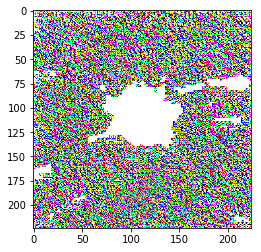

In [223]:
import matplotlib.pyplot as plt
gradient_image = evaluated_gradients[0][0]
gradient_image = gradient_image*(1/abs(np.min(gradient_image)))+1
#g1 = gradient_image-np.min(gradient_image)
#g2 = g1/(np.max(gradient_image)-np.min(gradient_image))
imgplot = plt.imshow(gradient_image, cmap=plt.cm.gray)
#imgplot = plt.imshow(g1)
plt.show()

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [24]:
temp =  gradient_image
gradient_image =  gradient_image*(1/abs(np.min(gradient_image)))
print(np.min(gradient_image))
print(np.max(gradient_image))
print(abs(np.min(gradient_image)))

-1.0
0.8765629
1.0


In [10]:
#163_184_962_963_LIDC-IDRI-0116_962_24_Highly-Suspicious_2_3_4_4_3_1_6_4_2_4
def get_salient_view(images, names, name):
    final_f = []
    final_n = []
    
    evaluated_gradients = []
    for image in images:
        sample = [image]
        val = sess.run(gradients, feed_dict={model.input: sample})
        evaluated_gradients.append(val)
    evaluated_gradients = np.array(evaluated_gradients)
    s = np.zeros(len(images))
    for i, e in enumerate(evaluated_gradients):
        s[i] = np.sum(np.absolute(e))
    tosort = []
    for i, k in enumerate(s):
        tosort.append([i, k])
    return [tosort, evaluated_gradients]

#tosort = get_salient_view(images, names, '571_3161_3162_LIDC-IDRI-0436_3161_48_Moderately-Suspicious_3_3_4_4_2_1_6_4_2_4')

In [15]:
def get_file_name(name):
    fn = '_'.join(name.split('/')[-1].split('.')[0].split('_')[1:])
    return fn

/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


[12, 9.555314364683136e-19]
[14, 9.214255390418335e-19]
[50, 6.049951954315505e-19]
[39, 6.132607460036984e-19]
2323_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg
16065_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg
35371_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg
36760_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg


/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/pranjal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


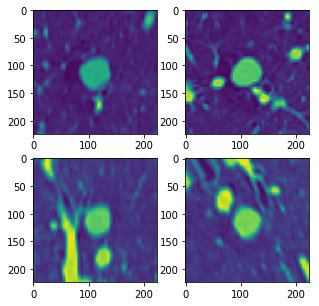

In [36]:
folder = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/Train/fold1/2/*.jpg'
files = glob.glob(folder)
images = []
names = []
image_name = '215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3'

for f in files:
    if  image_name in f:
        temp = imread(f)
        #print(temp.dtype)
        #temp = temp/255.0
        images.append(temp)
        names.append(f.split('/')[-1])
tosort, evaluated_gradients = get_salient_view(images, names, image_name)
p = sorted(tosort, key=lambda x: x[1], reverse=True)
print(p[0])
print(p[1])
print(p[-1])
print(p[-2])
print(names[p[0][0]])
print(names[p[1][0]])
print(names[p[-1][0]])
print(names[p[-2][0]])
folder = '/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/5fold_stratified_70/Train/fold1/2/'
%matplotlib inline
fig = plt.figure(figsize=(5, 5))
sub = fig.add_subplot(2, 2, 1)
sub.imshow(imread(folder+names[p[0][0]])[:, :, 0], cmap=plt.get_cmap('viridis'))
sub = fig.add_subplot(2, 2, 2)
sub.imshow(imread(folder+names[p[1][0]])[:, :, 0], cmap=plt.get_cmap('viridis'))
sub = fig.add_subplot(2, 2, 3)
sub.imshow(imread(folder+names[p[-1][0]])[:, :, 0], cmap=plt.get_cmap('viridis'))
sub = fig.add_subplot(2, 2, 4)
sub.imshow(imread(folder+names[p[-2][0]])[:, :, 0], cmap=plt.get_cmap('viridis'))
plt.show()

In [ ]:
a
5510_310_1677_1678_LIDC-IDRI-0196_1677_13_Highly-Suspicious_2_2_5_3_2_1_6_4_2_4.jpg
33781_310_1677_1678_LIDC-IDRI-0196_1677_13_Highly-Suspicious_2_2_5_3_2_1_6_4_2_4.jpg
1484_310_1677_1678_LIDC-IDRI-0196_1677_13_Highly-Suspicious_2_2_5_3_2_1_6_4_2_4.jpg
35025_310_1677_1678_LIDC-IDRI-0196_1677_13_Highly-Suspicious_2_2_5_3_2_1_6_4_2_4.jpg

b
9004_300_1621_1622_LIDC-IDRI-0191_1621_36_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg
19234_300_1621_1622_LIDC-IDRI-0191_1621_36_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg
35198_300_1621_1622_LIDC-IDRI-0191_1621_36_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg
26879_300_1621_1622_LIDC-IDRI-0191_1621_36_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg

a
Good
33310_304_1641_1642_LIDC-IDRI-0194_1641_21_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg
27530_304_1641_1642_LIDC-IDRI-0194_1641_21_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg
26673_304_1641_1642_LIDC-IDRI-0194_1641_21_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg
31971_304_1641_1642_LIDC-IDRI-0194_1641_21_Highly-Suspicious_2_3_4_3_4_1_6_4_2_4.jpg

a
okay
4852_40_203_204_LIDC-IDRI-0013_203_10_Moderately-Suspicious_2_4_5_4_1_1_6_4_2_3.jpg
33569_40_203_204_LIDC-IDRI-0013_203_10_Moderately-Suspicious_2_4_5_4_1_1_6_4_2_3.jpg
495_40_203_204_LIDC-IDRI-0013_203_10_Moderately-Suspicious_2_4_5_4_1_1_6_4_2_3.jpg
21562_40_203_204_LIDC-IDRI-0013_203_10_Moderately-Suspicious_2_4_5_4_1_1_6_4_2_3.jpg

b
good
201_42_213_214_LIDC-IDRI-0014_213_18_Moderately-Suspicious_1_4_4_4_1_1_6_4_2_3.jpg
23598_42_213_214_LIDC-IDRI-0014_213_18_Moderately-Suspicious_1_4_4_4_1_1_6_4_2_3.jpg
5941_42_213_214_LIDC-IDRI-0014_213_18_Moderately-Suspicious_1_4_4_4_1_1_6_4_2_3.jpg
22433_42_213_214_LIDC-IDRI-0014_213_18_Moderately-Suspicious_1_4_4_4_1_1_6_4_2_3.jpg

b
2323_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg
16065_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg
35371_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg
36760_215_1121_1122_LIDC-IDRI-0130_1121_14_Moderately-Suspicious_2_4_5_5_2_1_6_4_2_3.jpg

(63, 1, 1, 224, 224, 3)
(224, 224)


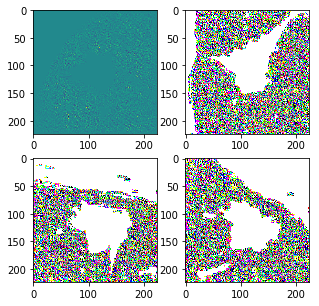

In [207]:
print(evaluated_gradients.shape)
%matplotlib inline
fig = plt.figure(figsize=(5, 5))
sub = fig.add_subplot(2, 2, 1)
gimage = evaluated_gradients[p[0][0]][0][0][:,:,0]*(1/abs(np.min(evaluated_gradients[p[0][0]][0][0][:,:,0])))+1
print(gimage.shape)
sub.imshow(gimage)
gimage = evaluated_gradients[p[1][0]][0][0]*(1/abs(np.min(evaluated_gradients[p[1][0]][0][0])))+1
sub = fig.add_subplot(2, 2, 2)
sub.imshow(gimage)
sub = fig.add_subplot(2, 2, 3)
gimage = evaluated_gradients[p[-1][0]][0][0]*(1/abs(np.min(evaluated_gradients[p[-1][0]][0][0])))+1
sub.imshow(gimage)
sub = fig.add_subplot(2, 2, 4)
gimage = evaluated_gradients[p[-2][0]][0][0]*(1/abs(np.min(evaluated_gradients[p[-2][0]][0][0])))+1
sub.imshow(gimage)
plt.show()

In [44]:
a = np.absolute(gradient_image)
print(a.shape)
print(np.sum(a[:, :, 0]))
print(np.sum(a[:, :, 1]))
print(np.sum(a[:, :, 2]))
print(np.sum(a))
#print(a)

(224, 224, 3)
50191.875
50168.65
50173.363
150533.9


(512, 512)


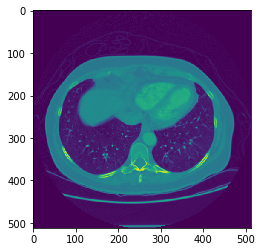

In [462]:
#a = dicom.read_file('/media/pranjal/part2/LUNG_challenge/Files/ISBI-deid-TRAIN/1001/20000102/anno_127.dcm')
a = dicom.read_file('/home/pranjal/LIDC-IDRI/LIDC-IDRI-0144/1.3.6.1.4.1.14519.5.2.1.6279.6001.219081768759399413645906161308/1.3.6.1.4.1.14519.5.2.1.6279.6001.249404938669582150398726875826/000055.dcm')
print(a.pixel_array.shape)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(a.pixel_array)
#print(a)

In [417]:
def get_nonzeroc(a):
    s = 0
    maxi = -1
    for i in range(1, a.shape[2]):
        t = np.max(a[:, :, i])
        if t > 0:
            #print(i)
            temp = np.count_nonzero(a[:, :, i])
            if temp > s:
                maxi = i
                s = temp
    nz = np.nonzero(a[:, :, maxi])
    xc = 0
    yc = 0
    for i, t in enumerate(nz[0]):
        xc = xc+nz[0][i]
        yc = yc+nz[1][i]
    print(len(nz[0]))
    xc = int(xc/len(nz[0]))
    yc = int(yc/len(nz[0]))
    return [xc, yc, maxi]

480
[187, 381, 94]
shape of a is  (512, 512)


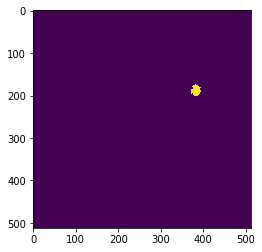

In [467]:
pl = get_nonzeroc(a)
print(pl)
print('shape of a is ', a[:, :, 94].shape)
#temp = a[151-25:151+25,424-25:424+25,94]
#print(temp.shape)
plt.imshow(a[:, :, 94])

(50, 50)
label im
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
nb labels 
2
sizes are  [  0. 432.  10.]  length of size  3
max label index  1
[ True False  True]
remove_pixel  [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
(50, 50)
slice(12, 40, None) slice(14, 39, None)
(28, 25)


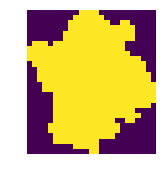

In [436]:
mask = temp > 0
print(mask.shape)
label_im, nb_labels = ndimage.label(mask)
print('label im')
print(label_im)
print('nb labels ')
print(nb_labels)
# Find the largest connected component
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
print('sizes are ', sizes, ' length of size ', len(sizes))
label_max_index = np.argmax(sizes)
print('max label index ', label_max_index)
mask_size = sizes < np.max(sizes)-1
print(mask_size)
remove_pixel = mask_size[label_im]
print('remove_pixel ', remove_pixel)
label_im[remove_pixel] = 0
labels = np.unique(label_im)
label_im = np.searchsorted(labels, label_im)
print(label_im.shape)
# Now that we have only one connected component, extract it's bounding box
slice_x, slice_y = ndimage.find_objects(label_im==label_max_index)[0]
print(slice_x, slice_y)
roi = mask[slice_x, slice_y]
print(roi.shape)
plt.figure(figsize=(4, 2))
plt.axes([0, 0, 1, 1])
plt.imshow(roi)
plt.axis('off')

plt.show()

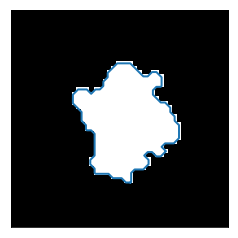

In [453]:
#edges1 = feature.canny(temp[12:40, 14:39])
#print(temp[12:40, 14:39])
from skimage import measure
contours = measure.find_contours(label_im, 0.8)
#print(contours)


fig, ax = plt.subplots()
ax.imshow(label_im, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
#plt.imshow(label_im)
plt.show()

In [457]:
print(np.array(contours).shape)

(1, 123, 2)


In [632]:
def get_center(image_slice):
    xc = 0
    yc = 0
    nz = np.nonzero(image_slice)
    for i, t in enumerate(nz[0]):
        xc = xc+nz[0][i]
        yc = yc+nz[1][i]
    xc = int(xc/len(nz[0]))
    yc = int(yc/len(nz[0]))
    return [xc, yc]

def get_volume(name, duration):
    #filename = '/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI-deid-TRAIN/'+name+'/'+duration
    filename = '/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI_CHALLENGE_TESTING_PHASE_2018/ISBI_TESTING_SET_DICOM_1/'+name+'/'+duration
    file = glob.glob(filename+'/*.dcm')[0]
    adicom = dicom.read_file(file)
    pixel_spacing   = float(adicom.PixelSpacing[0])
    slice_thickness = float(adicom.SliceThickness)
    #a = nifti_2_numpy('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/segmask_nii/'+name+'_Y'+duration+'.nii')
    a = nifti_2_numpy('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI_CHALLENGE_TESTING_PHASE_2018/Anonymized_Segs/'+name+'_Y'+duration+'.nii')
    s    = 0
    maxi = -1
    zcount    = 0
    diametera  = 0
    diameterb  = 0
    dimension = 25
    volume  = 0
    for i in range(1, a.shape[2]):
        t = np.max(a[:, :, i])
        nonzero = np.count_nonzero(a[:, :, i])
        if t > 0:
            #print(duration, i, 'nonzero count ', nonzero)
            mask = a[:, :, i] > 0
            mask = ndimage.binary_fill_holes(mask).astype(int)
            label_im, nb_labels = ndimage.label(mask)
            sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
            label_max_index = np.argmax(sizes)
            mask_size    = sizes < np.max(sizes)-1
            remove_pixel = mask_size[label_im]
            label_im[remove_pixel] = 0
            nonzerot = np.count_nonzero(label_im)
            
            xc, yc = get_center(label_im)
            temp = a[xc-dimension:xc+dimension,yc-dimension:yc+dimension, i]
            mask = temp > 0
            mask = ndimage.binary_fill_holes(mask).astype(int)
            label_im, nb_labels = ndimage.label(mask)
            sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
            label_max_index = np.argmax(sizes)
            mask_size    = sizes < np.max(sizes)-1
            remove_pixel = mask_size[label_im]
            label_im[remove_pixel] = 0
            nonzerot = np.count_nonzero(label_im)
            #if nonzerot < 5:
            #print(duration, name, 'continuing  for ', i, nonzerot)
            #continue
            slice_x, slice_y = ndimage.find_objects(label_im==label_max_index)[0]
            contours = measure.find_contours(label_im, 0.8)
            contours = np.array(contours)
            #if len(contours[0]) <3:
            #    continue
            #print('contours shape ', contours.shape, len(contours[0]), contours)
            if contours.shape[0] != 1:
                if name == '1003':
                    print(duration, i, 'nonzero count ', nonzero)
                    print(contours)
                contours = np.array([contours[0]])
                #print(contours.shape)
            x = contours[0, :, 0]*pixel_spacing
            y = contours[0, :, 1]*pixel_spacing
            area     = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
            volume   = volume+area*slice_thickness
            #print(slice_x)
            #print(slice_y)
            temp_maxa = abs(slice_x.stop-slice_x.start)*pixel_spacing
            temp_maxb = abs(slice_y.stop-slice_y.start)*pixel_spacing
            zcount = zcount+1
            if temp_maxa > diametera:
                diametera =  temp_maxa
            if temp_maxb > diameterb:
                diameterb = temp_maxb
            #print(zcount, slice_thickness, diameter, pixel_spacing)
    return [np.max([zcount*slice_thickness, diametera, diameterb]), volume, np.max([diametera, diameterb])/np.min([diametera, diameterb])]

In [629]:
arr = []
value = {}
value['CANCER'] = 1
value['NONCANCER'] = 0
keys = list(labels.keys())
keys.sort()
train = ''
for k in keys:
    #print(k)
    a = get_volume(str(k), '19990102')
    b = get_volume(str(k), '20000102')
    temp = np.array([a, b])
    temp = temp.flatten()
    temp = list(temp)
    dt = (20000102 - 19990102)*((np.log(2)/(np.log(temp[4])-np.log(temp[1]))))
    temp.append(dt)
    temp.append(value[labels[k]])
    arr.append(temp)
    temp.insert(0, k)
    sp = ','.join(map(str, temp))
    train = train+'\n'+sp
    print(temp)
trainfile = open('/home/pranjal/train.csv', 'w')
trainfile.write(train)
trainfile.close()

1001 [1001, 14.0, 235.03875732421875, 1.25, 18.0, 749.66650390625, 1.411764705882353, 5976.035135584242, 1]
1003 [1003, 35.0, 754.8776425928663, 1.0, 22.5, 592.4438995166861, 1.1666666666666667, -28607.042588836845, 0]
1004 [1004, 17.5, 958.8592529296875, 1.2352941176470589, 11.953125, 578.9492797851562, 1.1333333333333333, -13738.488685233218, 1]
1005 [1005, 10.0, 177.88304430058633, 1.090909090909091, 18.69140625, 1387.1556243896484, 1.1153846153846154, 3374.8111726607376, 1]
1006 [1006, 22.5, 252.8698815289036, 1.0, 22.5, 315.3345507129302, 1.1111111111111112, 31398.35331605173, 0]
1007 [1007, 24.0, 1734.8887939453125, 1.1111111111111112, 24.0, 1992.8441162109375, 1.1764705882352942, 50003.58146761333, 0]
1008 [1008, 5.625, 100.64453125, 1.125, 12.5, 360.4336460714825, 1.0, 5433.409759931811, 1]
1009 [1009, 8.476562, 166.43821217641698, 1.111111111111111, 11.6015625, 359.28226318359475, 1.0714285714285714, 9007.94575959542, 0]
1010 [1010, 22.5, 200.5078125, 1.1111111111111112, 22.5,

In [626]:
trainfile = open('/home/pranjal/train.csv', 'w')
trainfile.write(train)
trainfile.close()

In [634]:
arr = []
test = ''
for i in range(2000, 2070):
    a = get_volume(str(i), '19990102')
    b = get_volume(str(i), '20000102')
    temp = np.array([a, b])
    temp = temp.flatten()
    temp = list(temp)
    dt = (20000102 - 19990102)*((np.log(2)/(np.log(temp[4])-np.log(temp[1]))))
    temp.append(dt)
    temp.append(value[labels[k]])
    arr.append(temp)
    temp.insert(0, i)
    sp = ','.join(map(str, temp))
    test = test+'\n'+sp
    print(temp)
trainfile = open('/home/pranjal/test.csv', 'w')
trainfile.write(test)
trainfile.close()

[2000, 7.734375, 237.23052978515625, 1.0, 9.140625, 324.24224853515625, 1.0833333333333333, 22183.65227452228, 1]
[2001, 5.4687504, 28.953937951366242, 1.0, 8.125, 79.109375, 1.1818181818181819, 6896.1279918640475, 1]
[2002, 9.600000000000001, 98.55351562500002, 1.2857142857142858, 6.4, 45.68608105468593, 1.2, -9015.89160525991, 1]
[2003, 8.496093, 155.81390681695302, 1.3636363636363638, 7.9296868, 174.3570706573846, 1.0, 61644.3506302974, 1]
[2004, 5.0, 21.87713623046875, 1.2, 2.734375, 11.5740966796875, 1.0, -10887.0282711503, 1]
[2005, 13.671875, 523.3016967773438, 1.3888888888888888, 30.0, 7319.315185546875, 1.048780487804878, 2627.4346321256694, 1]
[2006, 7.5, 118.72918585811703, 1.0, 5.0, 59.04699970511274, 1.1666666666666665, -9923.204719219104, 1]
[2007, 11.312496, 287.7133211618036, 1.4545454545454546, 9.84375, 160.477294921875, 1.75, -11872.778518802175, 1]
[2008, 11.460942000000001, 574.893189028935, 1.0588235294117647, 12.617178000000001, 829.4802572465596, 1.0, 18906.67590

In [599]:
pq = np.array([[7.734375, 237.23052978515625], [9.140625, 324.24224853515625]])
pl = pq.flatten()
print(pl)

[  7.734375   237.23052979   9.140625   324.24224854]


255


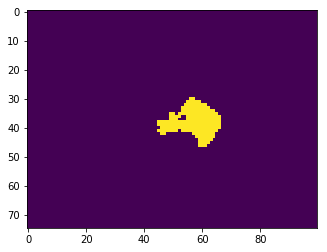

In [522]:
print(np.max(a[0:200, :, 99]))
plt.imshow(a[75:150, 200:300, 99])
plt.show()

1


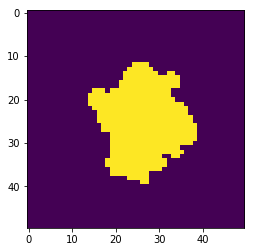

In [571]:
#t = ndimage.binary_fill_holes(a[130:200, 300:400, 103]).astype(int)
t = ndimage.binary_fill_holes(label_im).astype(int)
print(np.max(t))
plt.imshow(t)
plt.show()

In [460]:
contours = contours*
contours = np.array(contours)
x = contours[0, :, 0]
y = contours[0, :, 1]
print(len(x))
print(len(y))
area = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
print(area)

123
123
406.1800000000003


In [601]:
labels = {1001:'CANCER',
1003:'NONCANCER',
1004:'CANCER',
1005:'CANCER',
1006:'NONCANCER',
1007:'NONCANCER',
1008:'CANCER',
1009:'NONCANCER',
1010:'NONCANCER',
1011:'NONCANCER',
1012:'NONCANCER',
1014:'NONCANCER',
1015:'NONCANCER',
1016:'NONCANCER',
1017:'NONCANCER',
1021:'NONCANCER',
1022:'NONCANCER',
1024:'NONCANCER',
1028:'CANCER',
1031:'CANCER',
1032:'CANCER',
1034:'CANCER',
1040:'CANCER',
1045:'CANCER',
1048:'CANCER',
1050:'NONCANCER',
1051:'CANCER',
1052:'CANCER',
1064:'CANCER',
1066:'CANCER'}

In [282]:
#pixel spacing hash
pixelspacing_hash = {}
files = glob.glob('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI-deid-TRAIN/*')
for f in files:
    p = f+'/19990102/anno_3.dcm'
    a = dicom.read_file(p)
    #print(f.split('/')[-1], a.PixelSpacing)
    pixelspacing_hash[f.split('/')[-1]] = [a.PixelSpacing, a.SliceThickness]
print(pixelspacing_hash)
#Float.valueof(a)

{'1011': [['0.742188', '0.742188'], '2.5'], '1031': [['0.5664062', '0.5664062'], '2'], '1048': [['0.617188', '0.617188'], '2.5'], '1010': [['0.625', '0.625'], '2.5'], '1004': [['0.703125', '0.703125'], '2.5'], '1008': [['0.625', '0.625'], '2.5'], '1015': [['0.619140625', '0.619140625'], '3.2'], '1005': [['0.6445312', '0.6445312'], '2'], '1032': [['0.644531', '0.644531'], '2.5'], '1045': [['0.566406', '0.566406'], '2.5'], '1024': [['0.761719', '0.761719'], '2.5'], '1009': [['0.8476562', '0.8476562'], '2'], '1006': [['0.685547', '0.685547'], '2.5'], '1007': [['0.7421875', '0.7421875'], '2'], '1016': [['0.69921875', '0.69921875'], '3.2'], '1021': [['0.722656', '0.722656'], '2.5'], '1022': [['0.703125', '0.703125'], '2.5'], '1014': [['0.703125', '0.703125'], '2.5'], '1052': [['0.6640625', '0.6640625'], '2'], '1066': [['0.644531', '0.644531'], '2.5'], '1050': [['0.5976562', '0.5976562'], '2'], '1028': [['0.605469', '0.605469'], '2.5'], '1064': [['0.6640625', '0.6640625'], '2'], '1034': [['0

In [292]:
import nibabel as nib

volume = {}
def nifti_2_numpy(input_filepath):
    nifti = nib.load(input_filepath)
    return nifti.get_data()

def get_nonzero(a):
    s = 0
    for i in range(1, a.shape[2]):
        t = np.max(a[:, :, i])
        if t > 0:
            temp = np.count_nonzero(a[:, :, i])
            if temp > s:
                s = temp
    return s
    
for key in pixelspacing_hash:
    a = nifti_2_numpy('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/segmask_nii/'+key+'_Y19990102.nii')
    b = nifti_2_numpy('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/segmask_nii/'+key+'_Y20000102.nii')
    sa = get_nonzero(a)
    sb = get_nonzero(b)
    volume[key] = [key, sa, sb, sb/sa, labels[int(key)]]
    print(volume[key])

#print(a.shape)
#plt.imshow(a[:, :, 128])
#plt.show()

['1011', 41, 32, 0.7804878048780488, 'NONCANCER']
['1031', 442, 455, 1.0294117647058822, 'CANCER']
['1048', 153, 370, 2.418300653594771, 'CANCER']
['1010', 46, 54, 1.173913043478261, 'NONCANCER']
['1004', 228, 169, 0.7412280701754386, 'CANCER']
['1008', 60, 123, 2.05, 'CANCER']
['1015', 586, 527, 0.8993174061433447, 'NONCANCER']
['1005', 84, 408, 4.857142857142857, 'CANCER']
['1032', 107, 141, 1.3177570093457944, 'CANCER']
['1045', 89, 240, 2.696629213483146, 'CANCER']
['1024', 85, 62, 0.7294117647058823, 'NONCANCER']
['1009', 63, 130, 2.0634920634920637, 'NONCANCER']
['1006', 82, 94, 1.146341463414634, 'NONCANCER']
['1007', 269, 255, 0.9479553903345725, 'NONCANCER']
['1016', 76, 75, 0.9868421052631579, 'NONCANCER']
['1021', 17, 27, 1.588235294117647, 'NONCANCER']
['1022', 33, 76, 2.303030303030303, 'NONCANCER']
['1014', 38, 77, 2.026315789473684, 'NONCANCER']
['1052', 297, 492, 1.6565656565656566, 'CANCER']
['1066', 309, 374, 1.2103559870550162, 'CANCER']
['1050', 34, 50, 1.4705882352

In [558]:
def get_nonzeroa(a):
    s = 0
    for i in range(1, a.shape[2]):
        t = np.max(a[:, :, i])
        if t > 0:
            #print(i)
            temp = np.count_nonzero(a[:, :, i])
            if temp > s:
                s = i
    return s

a = nifti_2_numpy('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI_CHALLENGE_TESTING_PHASE_2018/Anonymized_Segs/2030_Y19990102.nii')
print('length is ', a.shape)
b = get_nonzeroa(a)
print(b)

length is  (512, 512, 150)
102


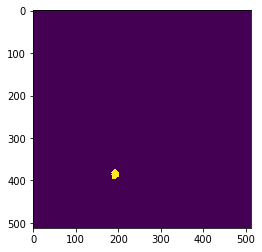

In [345]:
%matplotlib inline
import matplotlib.pyplot as plt

index = 95

#fig, (ax1, ax2) = plt.subplots(1, 2)

rimg = rotate(a[:, :, index], 270)
rimg = rimg[:, ::-1]
#rimg = rotate(rimg, 180)

#rimg = a[:, :, index]

#ax1.imshow(img1)
#ax2.imshow(rimg)

plt.imshow(rimg)

/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI_CHALLENGE_TESTING_PHASE_2018/ISBI_TESTING_SET_DICOM_1/2062/20000102/anno_104.dcm
(512, 512)


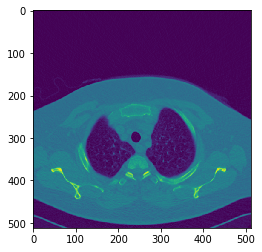

In [405]:
f = glob.glob('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/ISBI_CHALLENGE_TESTING_PHASE_2018/ISBI_TESTING_SET_DICOM_1/2062/20000102/*.dcm')
p = sorted(f, key=lambda p: int(p.split('/')[-1].split('.')[0].split('_')[1]), reverse=True)
p.reverse()
#print(p)
filename = p[101]
print(filename)
a = dicom.read_file(filename)
print(a.pixel_array.shape)
#plt.figure(figsize=(15,15))
plt.imshow(a.pixel_array)

99
100
101
102
103
104
105
106
107
108


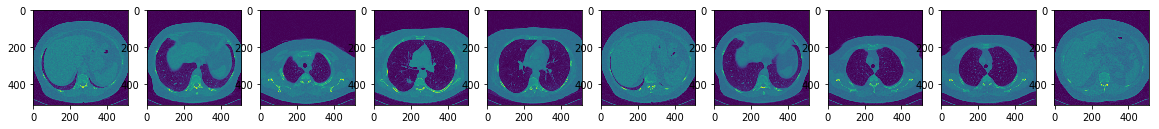

In [402]:
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 10
rows = 1
ind = 99
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    #index = ind+96
    #print(index)
    print(ind)
    filename = p[ind]
    #print(filename)
    a = dicom.read_file(filename)
    plt.imshow(a.pixel_array)
    ind = ind+1
plt.show()

73 max  0
74 max  72
75 max  133
76 max  115
77 max  96
78 max  0


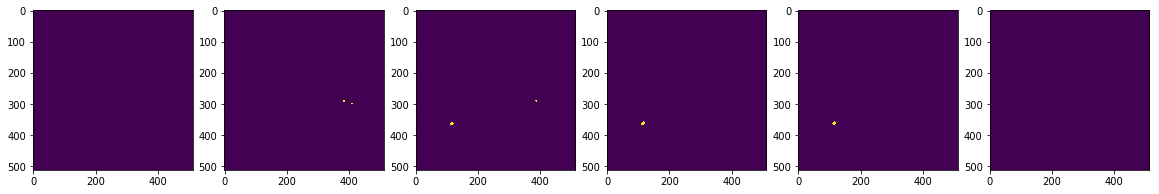

In [614]:
key = '1003'
a = nifti_2_numpy('/mnt/EYECHALLENGE/LUNGCHALLENGE/newdata/Files/segmask_nii/'+key+'_Y19990102.nii')
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 6
rows = 1
ind = 73
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    #index = ind+96
    #print(index)
    #print(ind)
    filename = p[ind]
    #print(filename)
    #a = dicom.read_file(filename)
    temp = rotate(a[:, :, ind], 270)
    print(ind, 'max ', np.count_nonzero(temp))
    temp = temp[:, ::-1]
    plt.imshow(temp)
    ind = ind+1
plt.show()


In [297]:
keylist = list(volume.keys())
keylist.sort()
for key in keylist:
    print(key, volume[key])

1001 ['1001', 116, 303, 2.6120689655172415, 'CANCER']
1003 ['1003', 127, 161, 1.2677165354330708, 'NONCANCER']
1004 ['1004', 228, 169, 0.7412280701754386, 'CANCER']
1005 ['1005', 84, 408, 4.857142857142857, 'CANCER']
1006 ['1006', 82, 94, 1.146341463414634, 'NONCANCER']
1007 ['1007', 269, 255, 0.9479553903345725, 'NONCANCER']
1008 ['1008', 60, 123, 2.05, 'CANCER']
1009 ['1009', 63, 130, 2.0634920634920637, 'NONCANCER']
1010 ['1010', 46, 54, 1.173913043478261, 'NONCANCER']
1011 ['1011', 41, 32, 0.7804878048780488, 'NONCANCER']
1012 ['1012', 83, 47, 0.5662650602409639, 'NONCANCER']
1014 ['1014', 38, 77, 2.026315789473684, 'NONCANCER']
1015 ['1015', 586, 527, 0.8993174061433447, 'NONCANCER']
1016 ['1016', 76, 75, 0.9868421052631579, 'NONCANCER']
1017 ['1017', 369, 472, 1.2791327913279134, 'NONCANCER']
1021 ['1021', 17, 27, 1.588235294117647, 'NONCANCER']
1022 ['1022', 33, 76, 2.303030303030303, 'NONCANCER']
1024 ['1024', 85, 62, 0.7294117647058823, 'NONCANCER']
1028 ['1028', 53, 116, 2.18

In [ ]:
print(a.shape)
for i in range(1, 157):
    t = np.max(a[:, :, i])
    if t > 0:
        print(i, t, np.count_nonzero(a[:, :, i]))
#print(np.min(a))

In [254]:
for i in range(10, 1):
    print(i)

In [13]:
files =  glob.glob('/mnt/EYECHALLENGE/CHALLENGE_1/Training Set/Apparent Retinopathy/*')
images = {}
for f in files:
    a = imread(f)
    #a = a[:, 300:4828-1200: ]
    #a = imresize(a, 0.25)
    f = f.split('/')[-1]
    p = '_'.join(f.split('.')[0].split('_')[0:2])
    images[p] = a

In [14]:
files =  glob.glob('/mnt/EYECHALLENGE/CHALLENGE_1/EX/*')
labels = {}
for f in files:
    a = imread(f)
    #a = a[:, 300:4828-1200: ]
    #a = imresize(a, 0.5)
    f = f.split('/')[-1]
    p = '_'.join(f.split('.')[0].split('_')[0:2])
    #print(p)
    labels[p] = a[:, :, 0]

In [20]:
files =  glob.glob('/mnt/EYECHALLENGE/CHALLENGE_1/Training Set/Apparent Retinopathy/*')

a = imread(files[0])
print(a.shape)

(2848, 4288, 3)


In [5]:
def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d):
    ret = []
    d2 = d * d
    n = len(points)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            count = 1
            point = [points[i][0], points[i][1]]
            taken[i] = True
            for j in range(i+1, n):
                if dist2(points[i], points[j]) < d2:
                    point[0] += points[j][0]
                    point[1] += points[j][1]
                    count+=1
                    taken[j] = True
            point[0] /= count
            point[1] /= count
            ret.append((point[0], point[1]))
    return ret

In [4]:
BATCH_SIZE = 5 # the higher the better
IMG_WIDTH  = 1600# for faster computing on kaggle
IMG_HEIGHT = 1100 # for faster computing on kaggle
IMG_CHANNELS = 3

In [134]:
x_train = []
y_train = []



#wd = int(IMG_WIDTH/2)

for k in labels:
    temp_image = images[k].astype(np.uint8)
    temp_label = labels[k].astype(np.uint8)
    x_train.append(temp_image)
    y_train.append(temp_label)
    #print(temp_image.shape)
#     image_patches = image_patch.extract_patches_2d(temp_image, (800, 800), max_patches=100, random_state=100)
#     label_patches = image_patch.extract_patches_2d(temp_label, (800, 800), max_patches=100, random_state=100)
#     for i, m in enumerate(label_patches):
#         if np.max(label_patches[i] > 0):
#             x_train.append(image_patches[i])
#             y_train.append(label_patches[i])
#     blobs_labels = ndimage.label(image)[0]
#     center = ndimage.measurements.center_of_mass(image, blobs_labels, list(range(1, np.max(blobs_labels)+1)))
#     fused = fuse(center, 100)
#     for c in fused:
#         x = int(c[0])
#         y = int(c[1])
#         if x+wd >= 2848:
#             x = 2848-wd
#         elif x-wd <= 0:
#             x = wd
#         if y+wd >= 4288:
#             y = 4288-wd
#         elif y-wd <= 0:
#             y = wd
#         temp_image = image[x-wd:x+wd, y-wd:y+wd]
#         x_train.append(temp_image)
#         temp_label = label[x-wd:x+wd, y-wd:y+wd]
#         y_train.append(temp_label/65535)


# rows = int(2848/IMG_WIDTH)-1
# cols = int(4288/IMG_WIDTH)-1
# print(rows, cols)
    
# for k in labels:
#     for i in range(rows):
#         for j in range(cols):
#             mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
#             temp_label = labels[k][i*IMG_WIDTH:(i+1)*IMG_WIDTH, j*IMG_WIDTH:(j+1)*IMG_WIDTH]
#             temp_image = images[k][i*IMG_WIDTH:(i+1)*IMG_WIDTH, j*IMG_WIDTH:(j+1)*IMG_WIDTH, :]
#             #print(labels[k].shape, images[k].shape, temp_label.shape, temp_image.shape, mask.shape, i, j)
#             mask = np.maximum(mask, temp_label)
#             if(np.max(mask) > 0):
#                 x_train.append(temp_image)
#                 y_train.append(mask)

x_train = np.array(x_train)
y_train = np.array(y_train)/255
y_train = np.expand_dims(y_train, axis=3)

print(x_train.shape)
print(y_train.shape)

(54, 2848, 4288, 3)
(54, 2848, 4288, 1)


In [ ]:
image = images['IDRiD_49'].astype(np.uint8, copy=True)
blobs_labels = ndimage.label(image)[0]
center = ndimage.measurements.center_of_mass(image, blobs_labels, list(range(1, np.max(blobs_labels)+1)))
print(len(center))
fused = fuse(center, 150)
print(len(fused))
print(fused)

In [132]:
print(image.shape)
blobs_labels = ndimage.label(image)[0]
center = ndimage.measurements.center_of_mass(image, blobs_labels)#, list(range(1, np.max(blobs_labels)+1)))
print(center)

(2848, 4288)
(1533.0863888605181, 1700.9351955877846)


In [6]:
from keras.preprocessing import image

seed = 100

p = np.random.permutation(len(x_train))
X_train = x_train[p]
Y_train = y_train[p]
    
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', horizontal_flip=True, vertical_flip=True)
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', horizontal_flip=True, vertical_flip=True)

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x = image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y = mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val  = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val = image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val = mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [246]:
# Build U-Net model
inputs = Input((832, 832, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
#model.summary()

In [ ]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=200, steps_per_epoch=50,
                              epochs=50, callbacks=[earlystopper, checkpointer])

In [50]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
val_label = Y_train[int(Y_train.shape[0]*0.9):]
val_orig  = X_train[int(X_train.shape[0]*0.9):]
#preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

# # Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))

160/168 [===========================>..] - ETA: 0s

In [ ]:
files = glob.glob('/mnt/EYECHALLENGE/CHALLENGE_1/Training_a_and_b/*.jpg')

def get_thresh(h):
    s = np.sum(h[0])
    #print('sum ', s)
    reversed_arr = h[0][::-1]
    reversed_p = h[1][::-1]
    #print(s)
    st = 0
    p = 0.045
    thresh = 10
    for i, t in enumerate(reversed_arr):
        st = st+t
        if st > p*s:
            thresh =  reversed_p[i]
            #print(reversed_p[i])
            break
    return thresh

for f in files:
    name = f.split('/')[-1].split('.')[0]
    a = imread(f)
    img = color.rgb2gray(a.astype(np.uint8))
    h = np.histogram(img.ravel(), 256, [0.1, 1])
    thresh = get_thresh(h)
    temp = img
    temp[temp<thresh]=0
    temp = ndimage.binary_erosion(temp, structure=np.ones((59,59))).astype(temp.dtype)
    temp = ndimage.binary_erosion(temp, structure=np.ones((49,49))).astype(temp.dtype)
    coords = np.column_stack(np.nonzero(temp))
    model, inliers = measure.ransac(coords, measure.CircleModel,
                                min_samples=30, residual_threshold=1,
                                max_trials=500)
    print(name, int(model.params[0]), int(model.params[1]))
    rr, cc = draw.circle(model.params[0], model.params[1], model.params[2], shape=img.shape)
    imga = color.rgb2gray(a.astype(np.uint8))
    imga[rr, cc] = 1
    imsave('./eye/'+name+'.jpg', imga)

/home/pranjal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


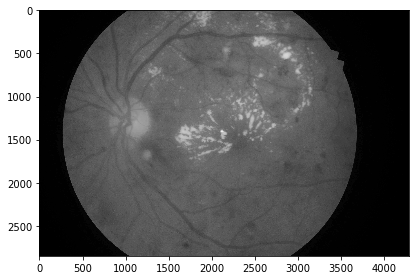

In [221]:
from skimage import color
a = x_train[12]
a = imread('/mnt/EYECHALLENGE/CHALLENGE_1/Training_a_and_b/IDRiD_347.jpg')
img = color.rgb2gray(a.astype(np.uint8))
#img[:, 2144-400:2144+400] = 0
imshow(img)
plt.show()

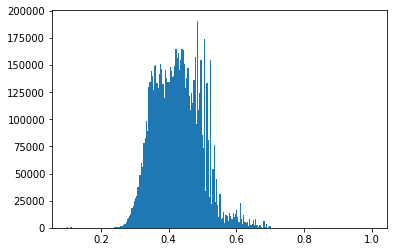

In [92]:
plt.hist(img.ravel(),256,[0.1,1]); 
plt.show()

In [93]:
np.max(img.ravel())

0.7174882352941178

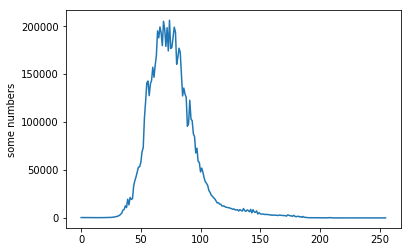

In [222]:
h = np.histogram(img.ravel(), 256, [0.1, 1])
plt.plot(h[0])
plt.ylabel('some numbers')
plt.show()

In [223]:
s = np.sum(h[0])
print('sum ', s)
reversed_arr = h[0][::-1]
reversed_p = h[1][::-1]
#print(s)
st = 0
p = 0.045
thresh = 10
for i, t in enumerate(reversed_arr):
    st = st+t
    if st > p*s:
        thresh =  reversed_p[i]
        print(reversed_p[i])
        break

sum  8424272
0.51484375


In [ ]:
img = color.rgb2gray(a.astype(np.uint8))
temp = img
temp[temp<0.55]=0


/home/pranjal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/pranjal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.5/site-packages/mpl_toolkits/axes_grid1/axes_size.py:269: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  elif cbook.is_string_like(size):


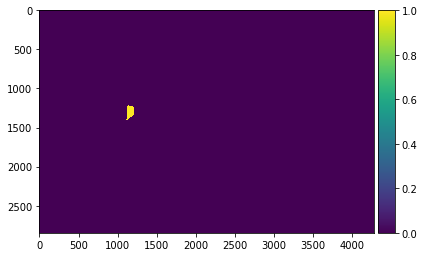

In [224]:
img = color.rgb2gray(a.astype(np.uint8))
#img[:, 2144-400:2144+400] = 0
tempb = img
tempb[tempb<thresh]=0
tempb = ndimage.binary_erosion(tempb, structure=np.ones((59,59))).astype(tempb.dtype)
tempb = ndimage.binary_erosion(tempb, structure=np.ones((49,49))).astype(tempb.dtype)
imshow(tempb)
plt.show()

41.884845951600205


/home/pranjal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/pranjal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/home/pranjal/anaconda3/envs/tensorflow/lib/python3.5/site-packages/mpl_toolkits/axes_grid1/axes_size.py:269: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  elif cbook.is_string_like(size):


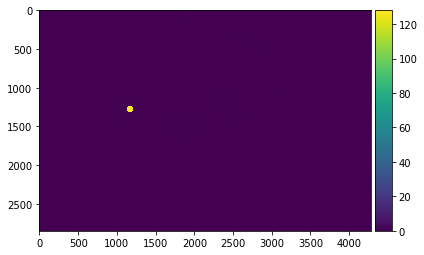

In [226]:
from skimage import measure, feature, io, color, draw

img = color.rgb2gray(a.astype(np.uint8))
temp = img
temp[temp<thresh]=0
temp = ndimage.binary_erosion(temp, structure=np.ones((59,59))).astype(temp.dtype)
temp = ndimage.binary_erosion(temp, structure=np.ones((49,49))).astype(temp.dtype)
#coords = np.column_stack(np.nonzero(img))
coords = np.column_stack(np.nonzero(temp))
model, inliers = measure.ransac(coords, measure.CircleModel,
                                min_samples=3, residual_threshold=1,
                                max_trials=500)
print(model.params[2])
rr, cc = draw.circle(model.params[0], model.params[1], model.params[2], shape=img.shape)
#rr, cc = draw.circle(model.params[0], model.params[1], 50, shape=img.shape)
img[rr, cc] = 128

imshow(img)
plt.show()

/home/pranjal/.local/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


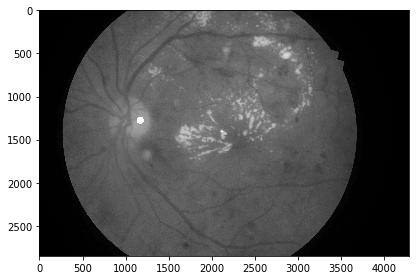

In [227]:
imga = color.rgb2gray(a.astype(np.uint8))
imga[rr, cc] = 1
#tempa = np.maximum(tempb, imga)
imshow(imga)
plt.show()

In [71]:
print(cc)

[2809 2810 2811 ... 2839 2840 2841]


In [25]:
print(np.max(img))

0.7174882352941178


In [48]:
import cv2

k = list(labels.keys())[10]
print(k)
image = images[k].astype(np.uint8)
label = labels[k].astype(np.uint8)
print(label.shape)
#imshow(image)
plt.show()

blobs_labels = ndimage.label(label)[0]
center = ndimage.measurements.center_of_mass(label, blobs_labels, list(range(1, np.max(blobs_labels)+1)))

x_train = []
y_train  = []

fused = fuse(center, 100)
for c in fused:
    x = int(c[0])
    y = int(c[1])
#     if x+256 >= 2848:
#         x = 2848-256
#     elif x-256 <= 0:
#         x = 256
#     if y+256 >= 4288:
#         y = 4288-256
#     elif y-256 <= 0:
#         y = 256
    print(x, y)
    temp_image = image[x-256:x+256, y-256:y+256]
    x_train.append(temp_image)
    temp_label = label[x-256:x+256, y-256:y+256]
    y_train.append(temp_label/65535)

print(center)
print(len(x_train))
print(len(y_train))

IDRiD_18
(2848, 4288)
315 3053
1354 3393
2149 1814
[(315.6923962502056, 3053.62019626117), (1354.5533360961458, 3393.627020306672), (2149.8403975993997, 1814.1792010502625)]
3
3


In [ ]:
# image = a
# for kp in keypoints:
#     print(kp.pt[0], kp.pt[1], kp.size, kp.response)
#     cv2.circle(image, (int(kp.pt[0]), int(kp.pt[1])), int(kp.size), (0, 0, 255))


#all_labels = measure.label(labels[k].astype(np.uint8, copy=True))
image = labels[k].astype(np.uint8, copy=True)
blobs_labels = ndimage.label(image)[0]
center = ndimage.measurements.center_of_mass(image, blobs_labels, list(range(1, np.max(blobs_labels)+1)))

print(np.max(blobs_labels))
print(center, len(center))
imshow(blobs_labels)
plt.show()

In [ ]:
x = np.min(int(center[-2][0]), 0)
y = int(center[-2][1])
print(x, y)
print(image.shape)
tm = image[x-256:x+256, y-256:y+256]
print(tm.shape)
imshow(tm)
plt.show()

In [ ]:
#LUNG CHALLENGE
